In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("homework_1.csv", encoding="latin-1")
df["EV"] = df['EV'].str.replace(",","").astype(float)
df["PSR"] = df['PSR'].str.replace("#DIV/0!","Nan").astype(float)
df = df.drop(columns=['Yt.2M','Yt.3M'])
# df.info()

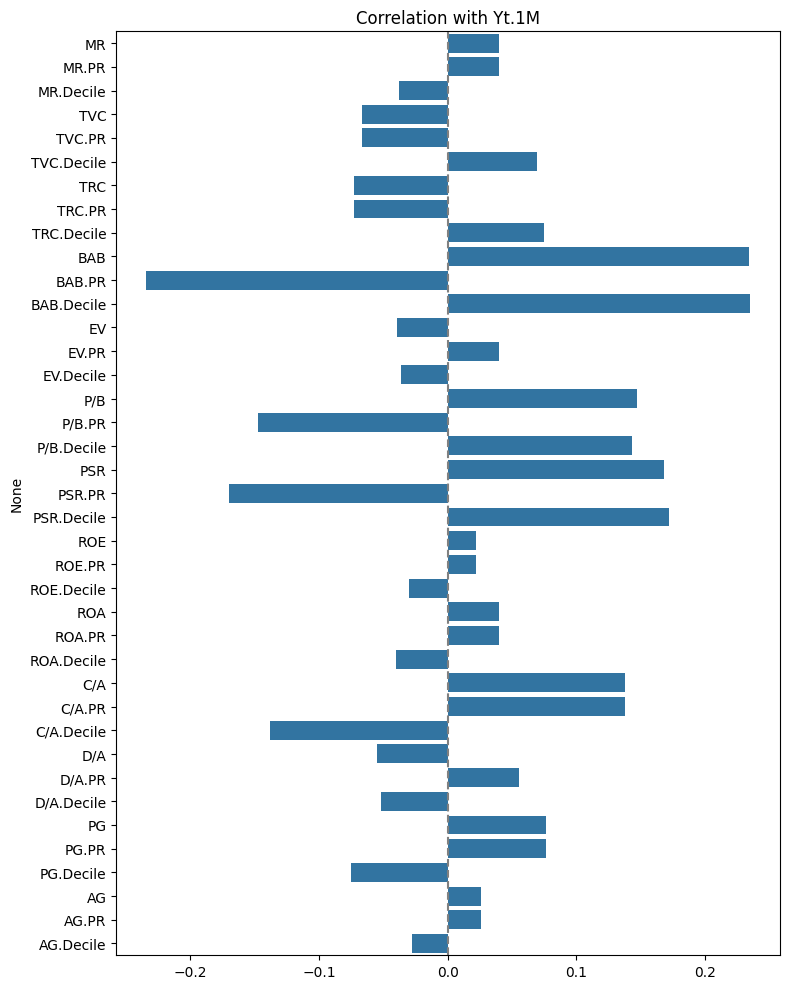

In [55]:
numeric_df = df.select_dtypes("number")
corr_with_target = numeric_df.corr(method="spearman")['Yt.1M'].drop('Yt.1M')

# Plot as horizontal barplot (nicer than a single-column heatmap)
plt.figure(figsize=(8, 10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with Yt.1M')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [63]:
basic_columns = ["Yt.1M","Industry","MR","TVC","TRC","BAB","EV","P/B","PSR","ROE","ROA","C/A","D/A","PG","AG"]
basic_df = df[basic_columns]

0 Yt.1M
1 MR
2 TVC
3 TRC
4 BAB
5 EV
6 P/B
7 PSR
8 ROE
9 ROA
10 C/A
11 D/A
12 PG
13 AG


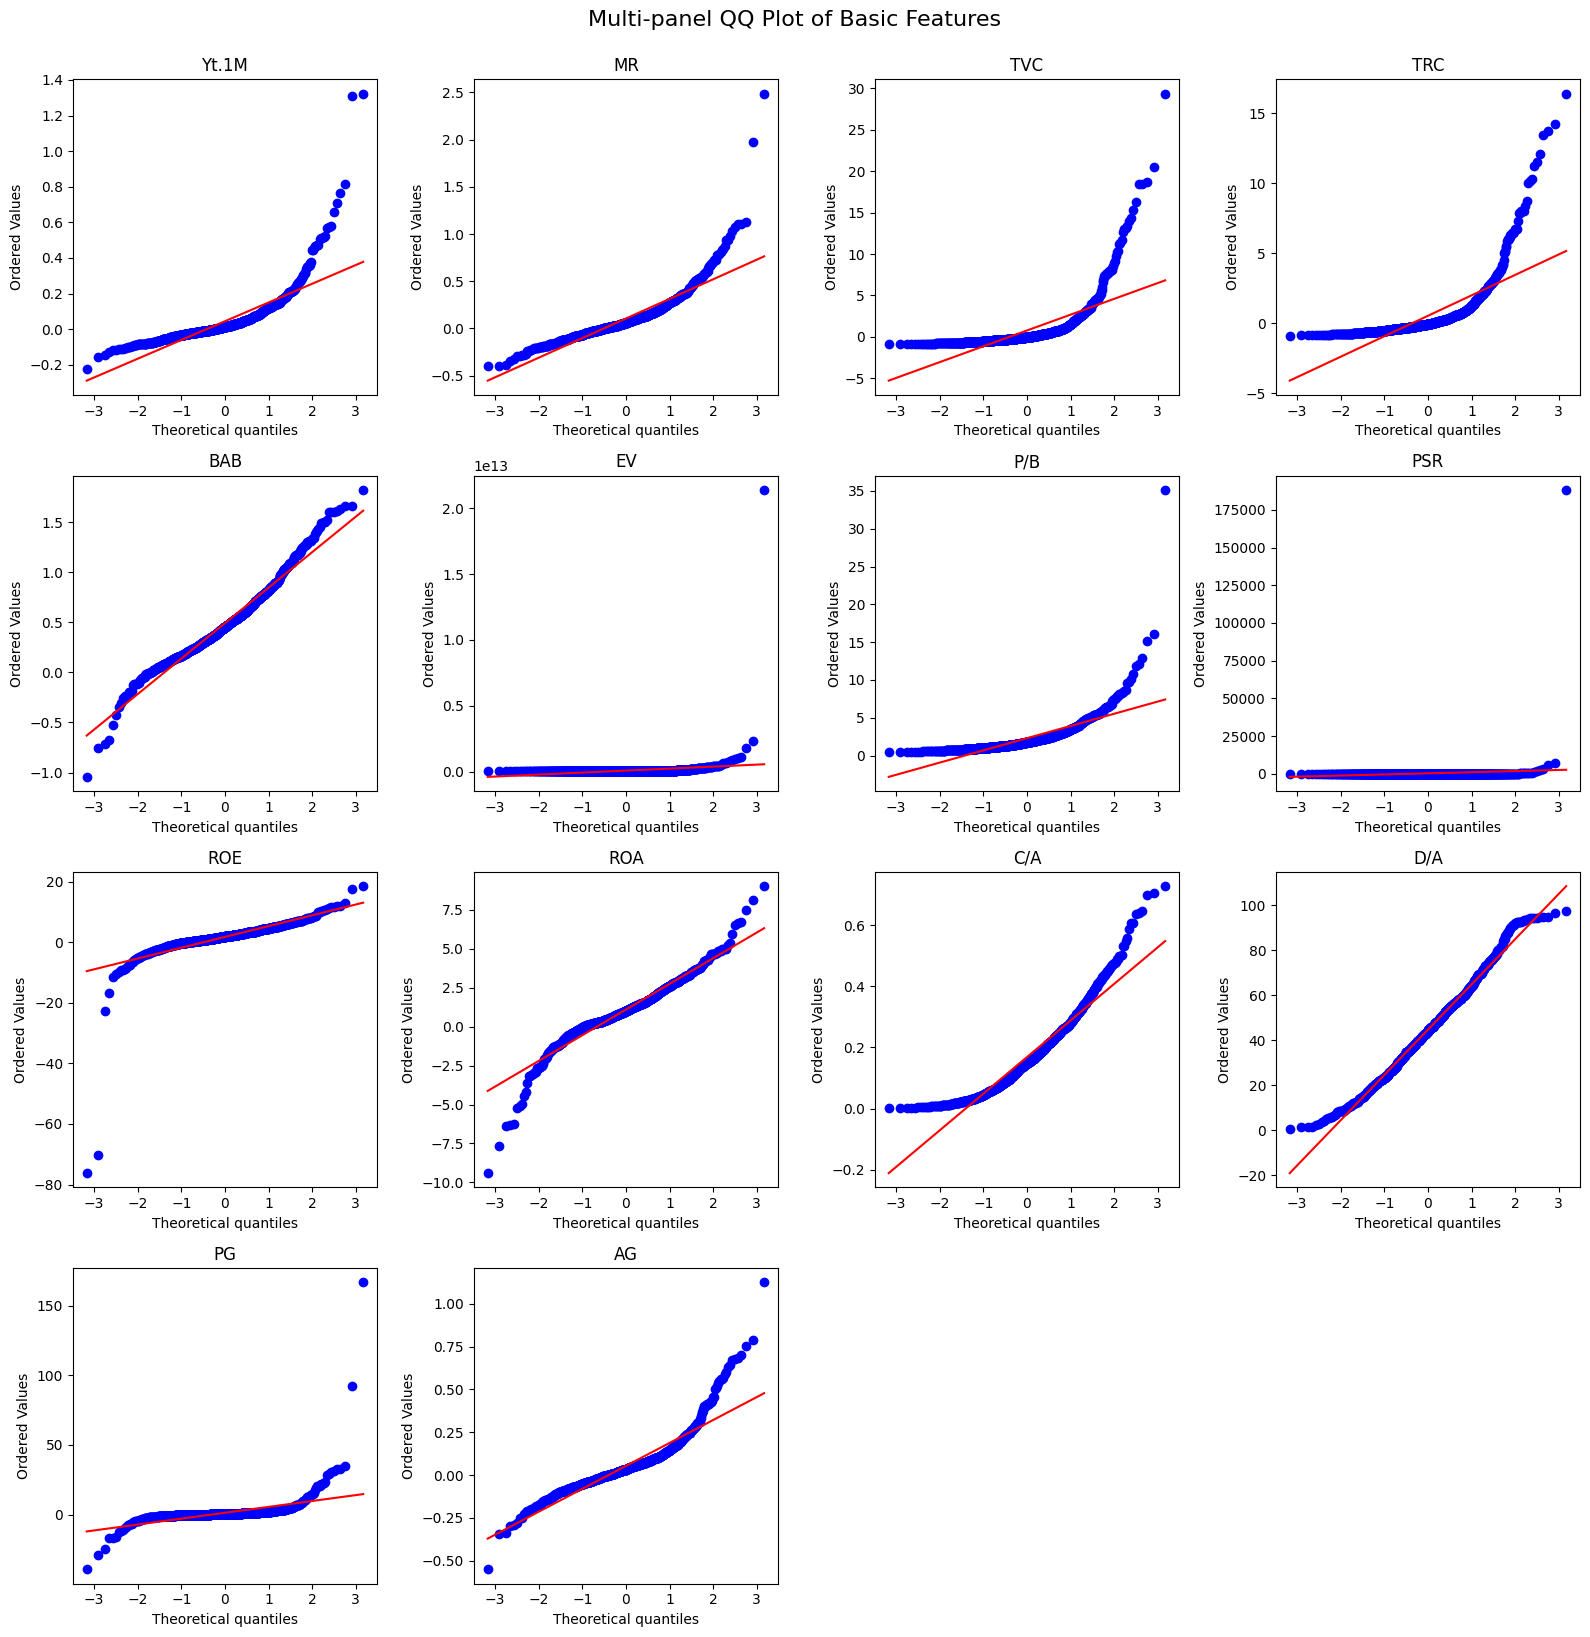

In [64]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import math

# Select only numeric columns (and drop NaNs just in case)
numeric_df = basic_df.select_dtypes(include='number').dropna()

# Setup the number of subplots
n = len(numeric_df.columns)
cols = 4  # number of columns in the plot grid
rows = math.ceil(n / cols)

# Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()  # Flatten in case of 2D array

# Generate each QQ plot
for i, col in enumerate(numeric_df.columns):
    print(i,col)
    stats.probplot(numeric_df[col], dist="norm", plot=axes[i])
    axes[i].set_title(col)

# Hide any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Multi-panel QQ Plot of Basic Features", fontsize=16, y=1.02)
plt.show()


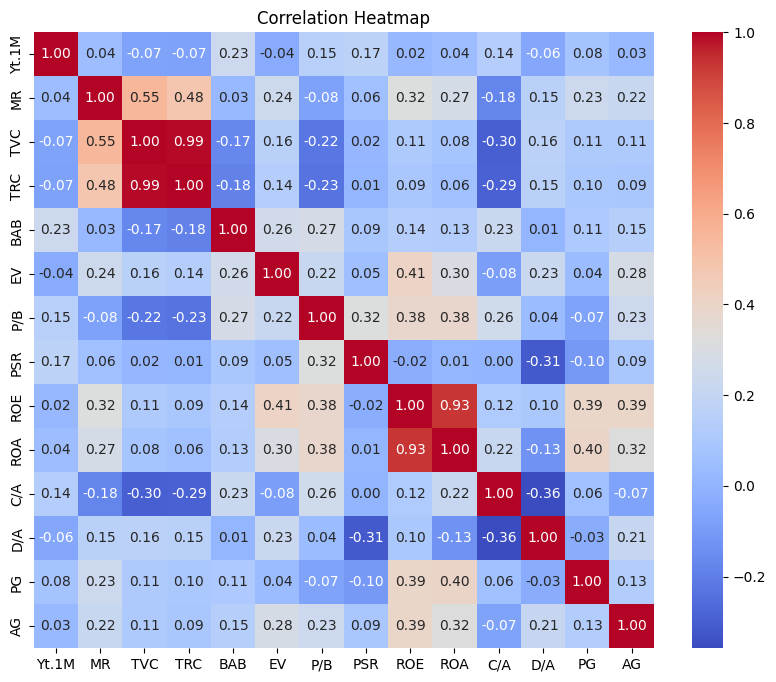

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numeric_df = basic_df.select_dtypes("number")
# numeric_df["TVC-TRC"] = numeric_df["TVC"]-numeric_df["TRC"]
# numeric_df["ROE-ROA"] = numeric_df["ROE"]-numeric_df["ROA"]

plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(numeric_df.corr(method="spearman"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [67]:
basic_df = basic_df.drop(columns=["TVC","ROE"])

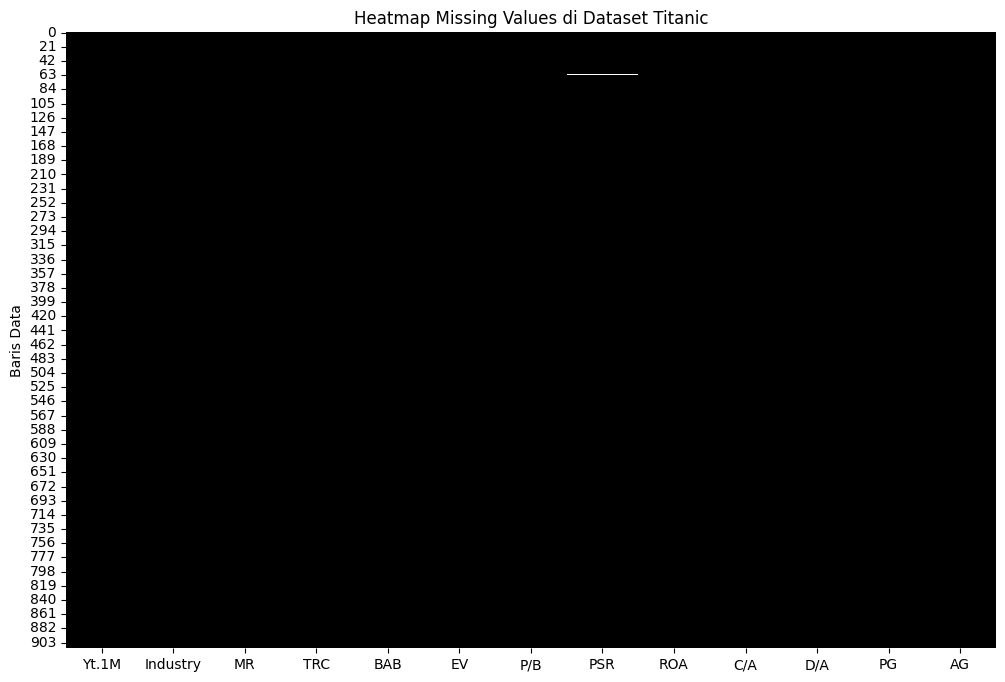

In [68]:
missing_matrix = basic_df.isnull().to_numpy()

# Balik warna (hitam untuk ada, putih untuk missing)
missing_matrix = np.where(missing_matrix, 0, 1)

# Buat heatmap
plt.figure(figsize=(12, 8))  # Sesuaikan ukuran jika perlu
sns.heatmap(missing_matrix, cmap='gray_r', cbar=False, xticklabels=basic_df.columns)
plt.title('Heatmap Missing Values di Dataset Titanic')
plt.ylabel('Baris Data')
plt.show()

In [69]:
basic_df = basic_df.dropna()

## Check if industry important

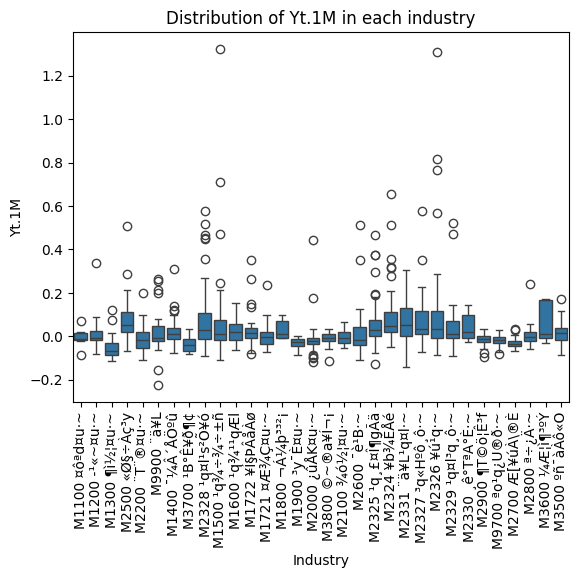

In [70]:
sns.boxplot(data=basic_df, x='Industry', y='Yt.1M')
plt.title("Distribution of Yt.1M in each industry")
plt.xticks(rotation=90)
plt.show()

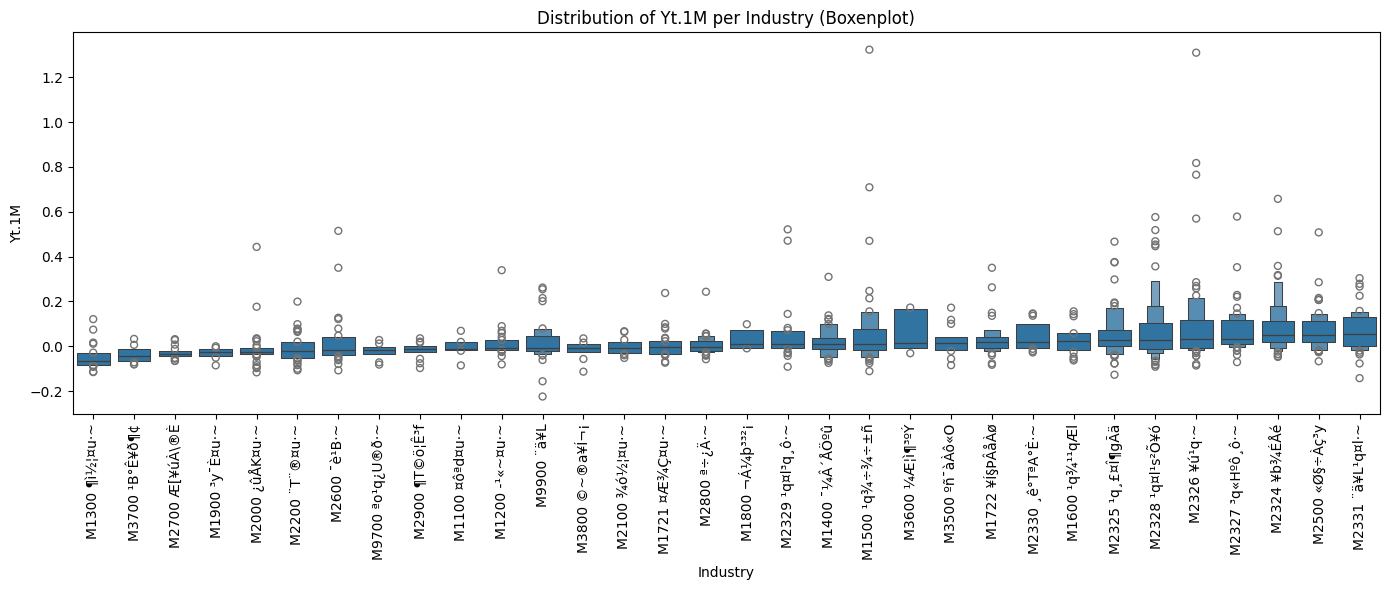

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort industries by median Yt.1M
industry_order = (
    basic_df.groupby("Industry")["Yt.1M"]
    .median()
    .sort_values()
    .index
)

plt.figure(figsize=(14, 6))
sns.boxenplot(data=basic_df, x="Industry", y="Yt.1M", order=industry_order)

plt.xticks(rotation=90)
plt.title("Distribution of Yt.1M per Industry (Boxenplot)")
plt.tight_layout()
plt.show()

## Dimensionality reduction for clustering and visualization.

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns

basic_df["Industry"] = df["Industry"]

In [73]:
import gower

distance_matrix = gower.gower_matrix(basic_df)
reducer = umap.UMAP(metric="precomputed")
X_umap = reducer.fit_transform(distance_matrix)

c:\Users\USER\.conda\envs\rust-pruning\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [74]:
from sklearn.preprocessing import MinMaxScaler
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
combined_df = pd.concat([basic_df.reset_index(drop=True), umap_df.reset_index(drop=True)], axis=1)
combined_df["Yt.1M.scaled"] = MinMaxScaler().fit_transform(combined_df["Yt.1M"].to_numpy().reshape(-1,1))

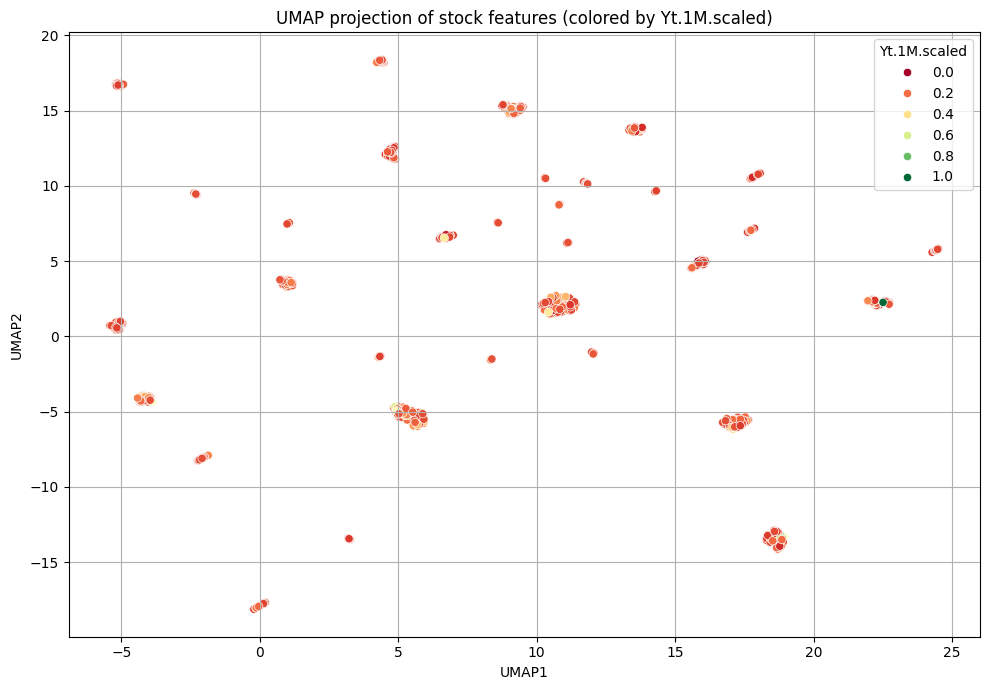

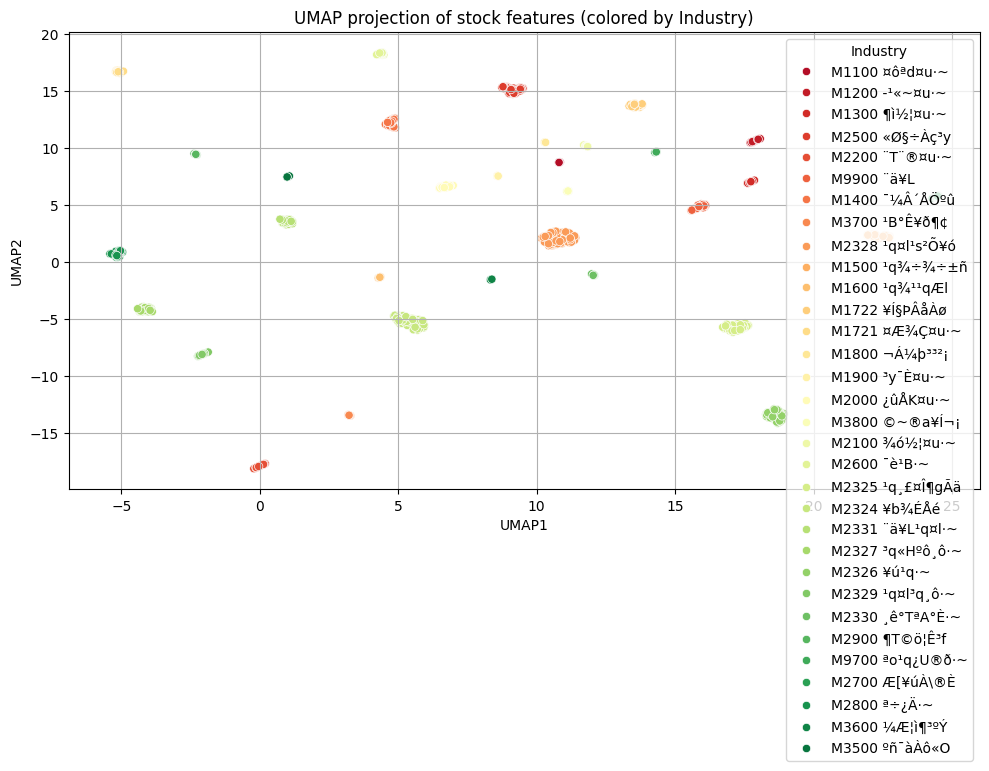

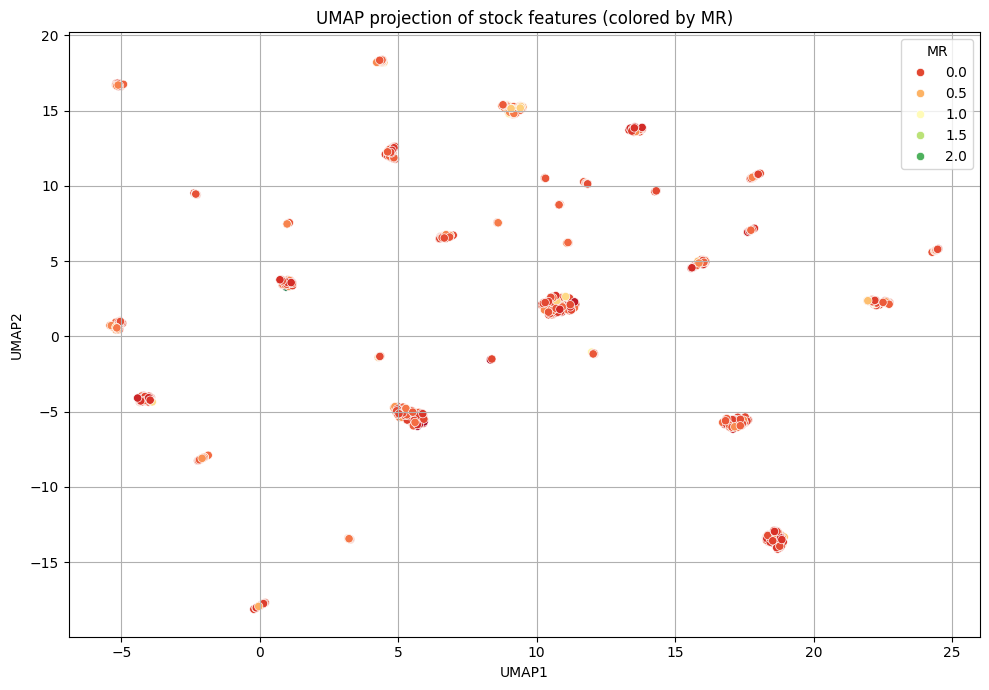

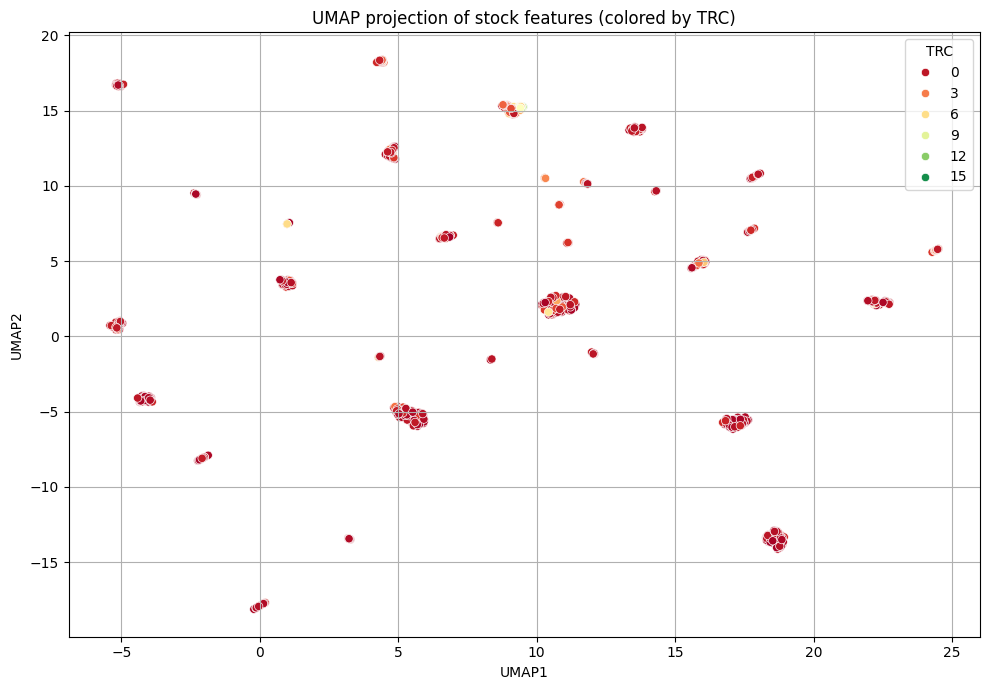

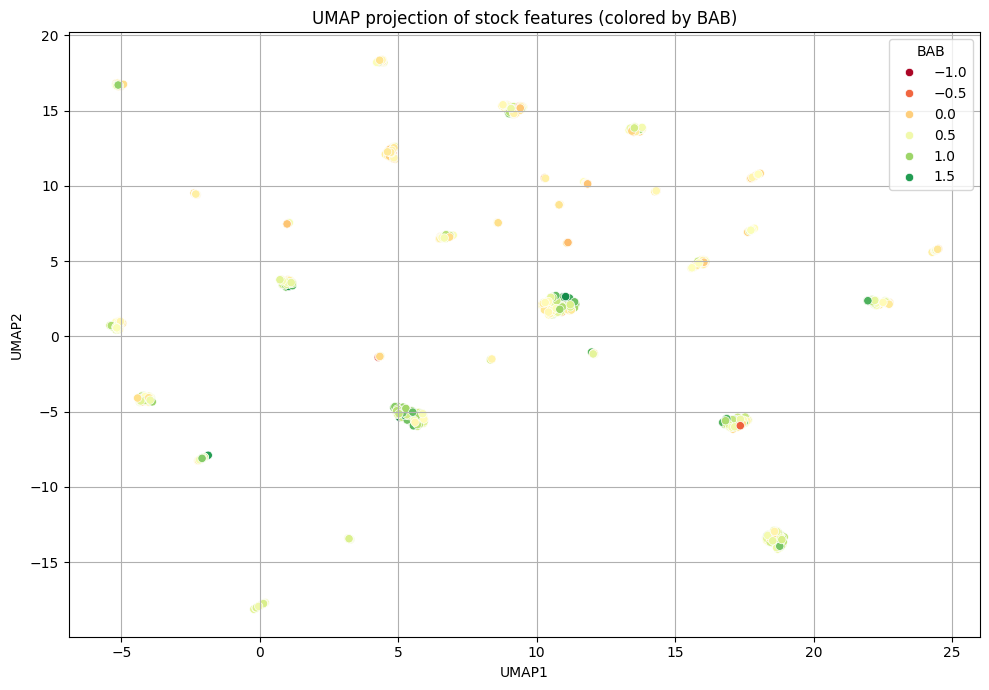

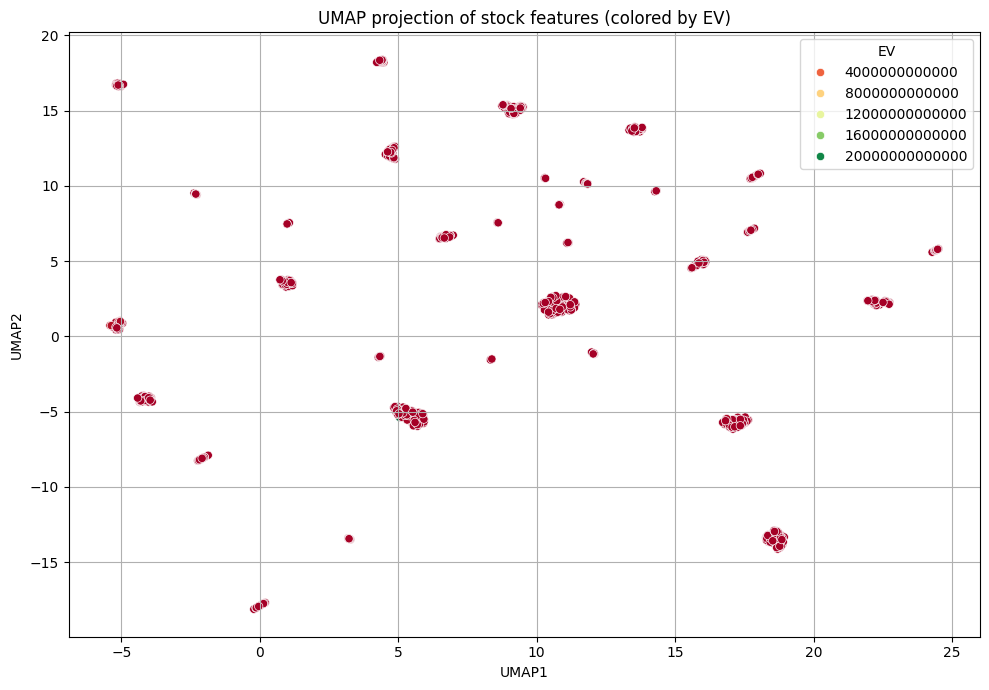

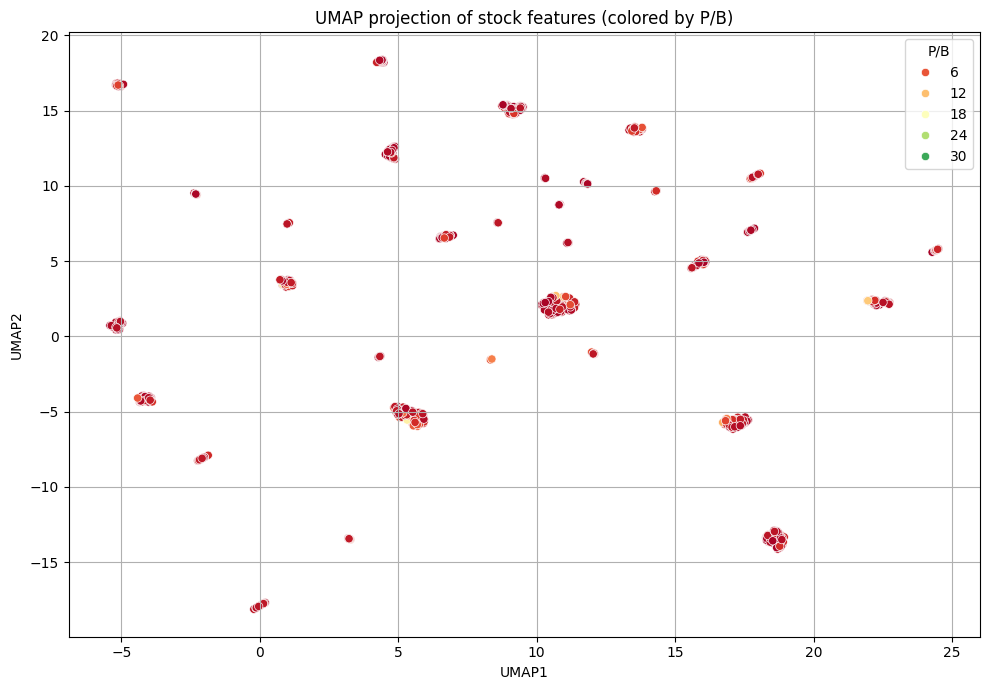

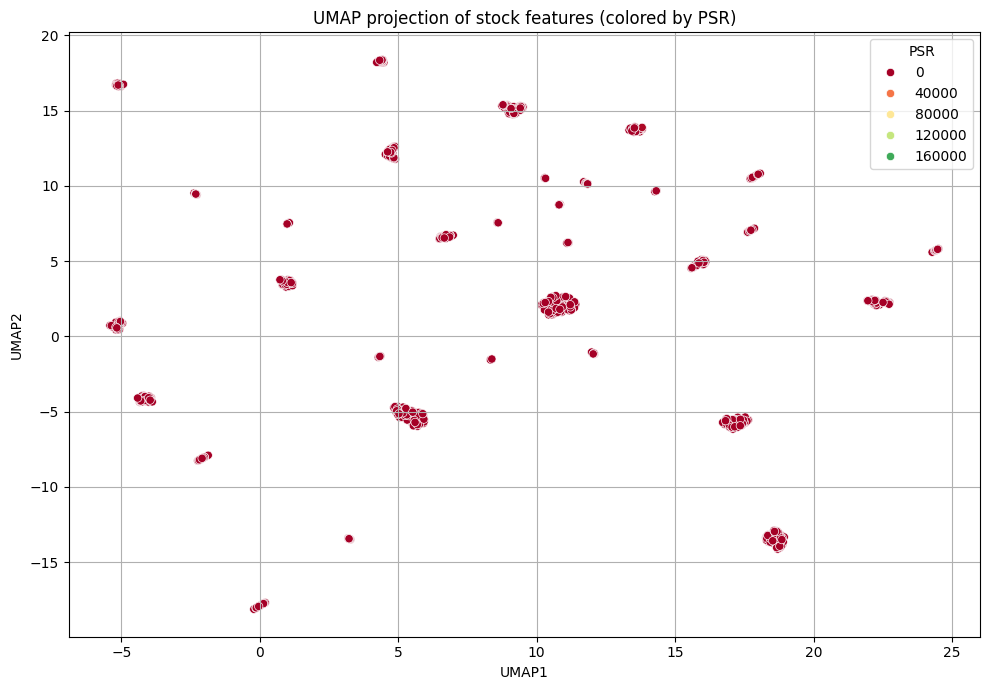

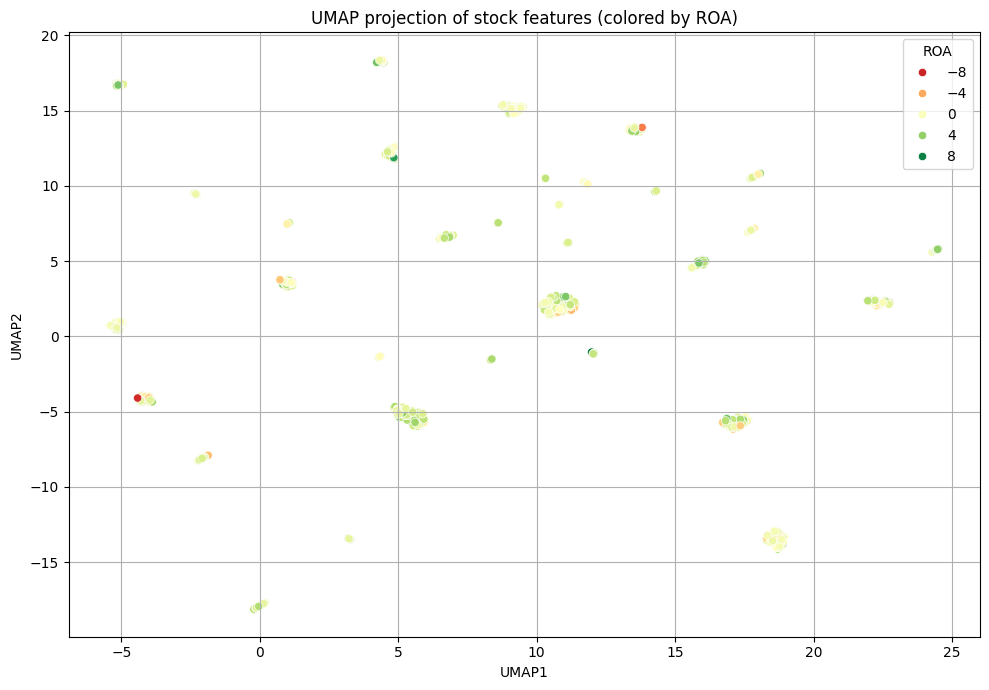

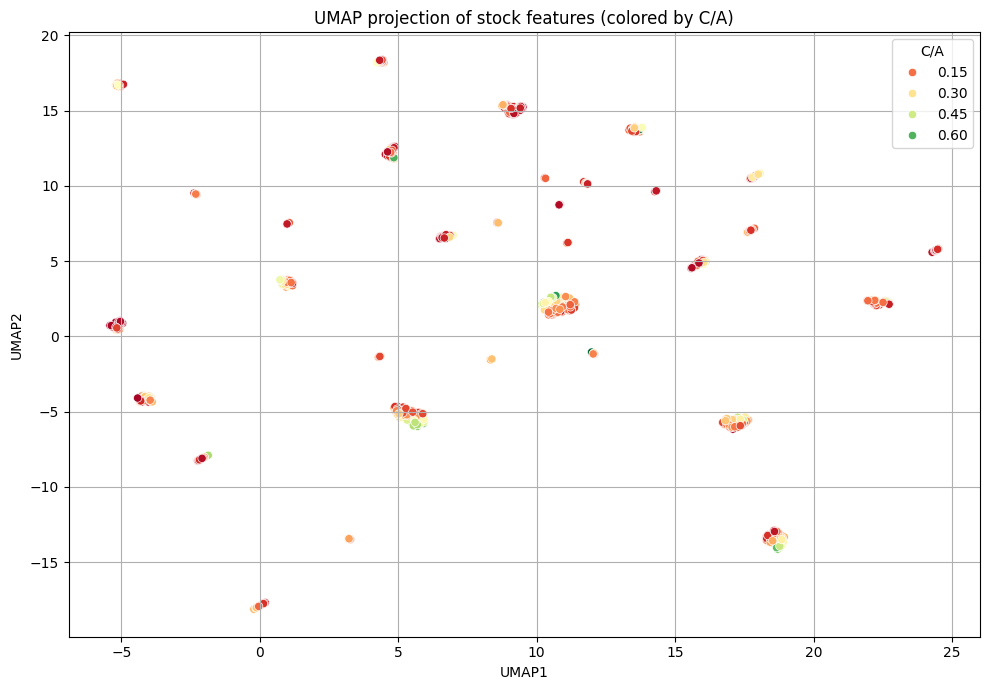

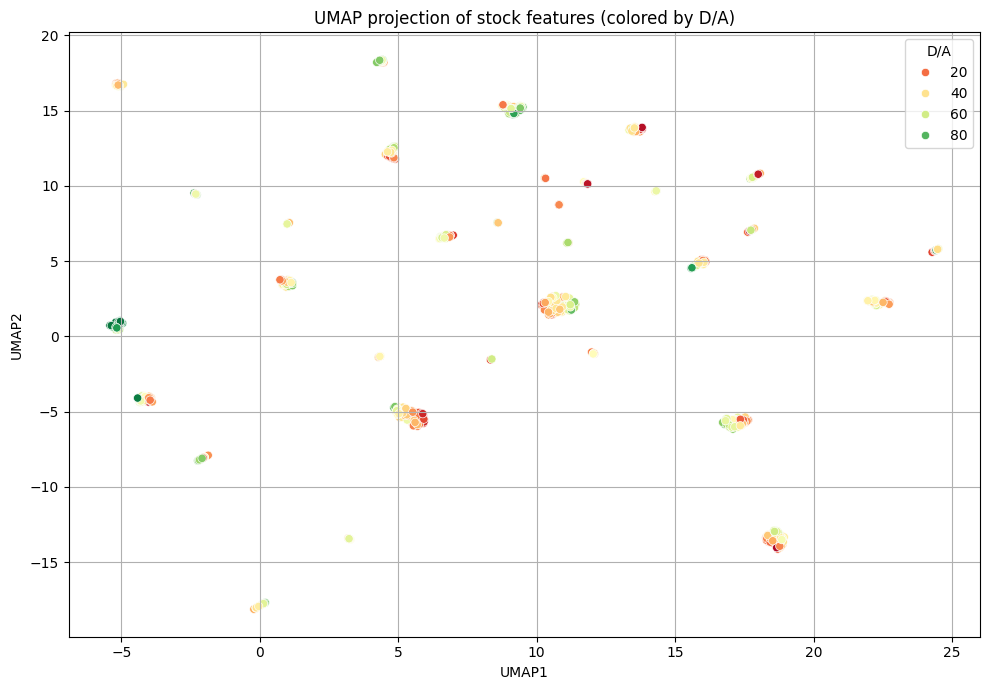

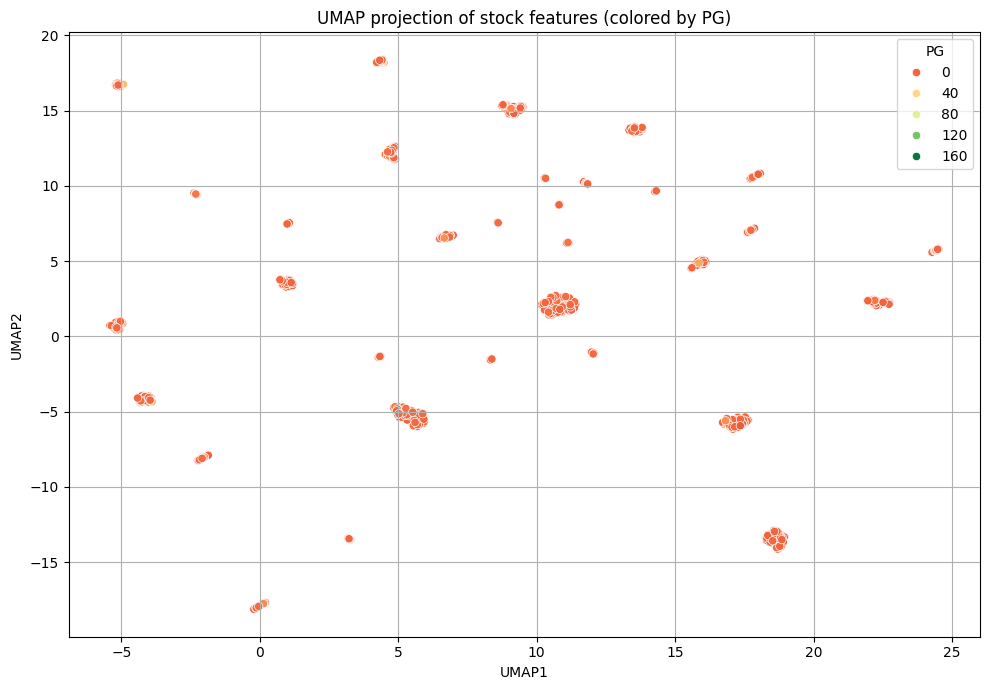

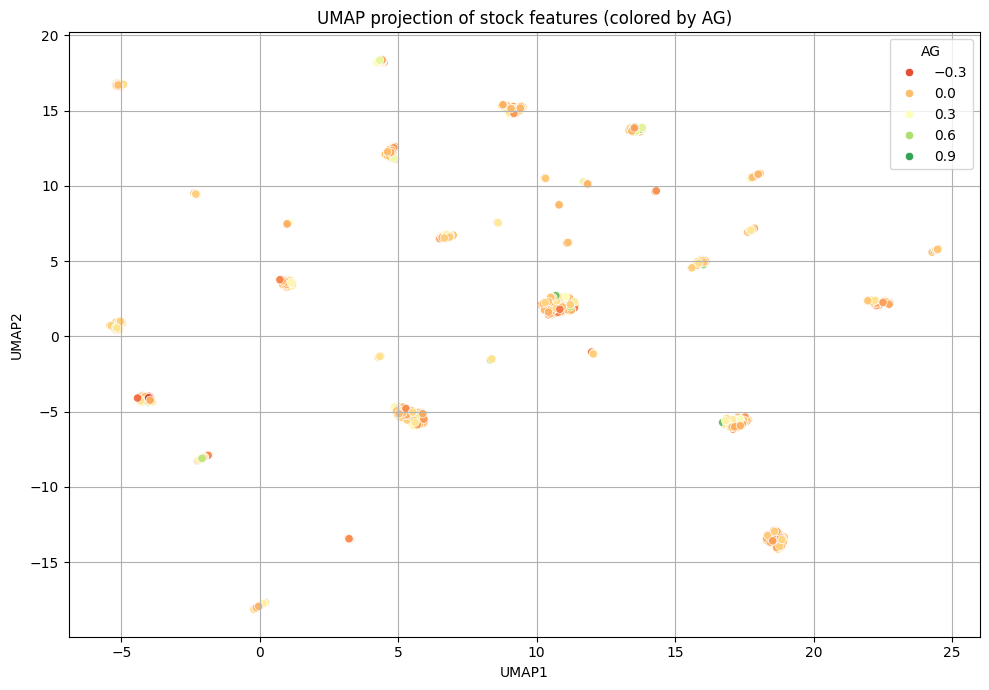

In [75]:
for column in ["Yt.1M.scaled","Industry","MR","TRC","BAB","EV","P/B","PSR","ROA","C/A","D/A","PG","AG"]:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=combined_df, x="UMAP1", y="UMAP2", hue=column, palette="RdYlGn")
    plt.title(f"UMAP projection of stock features (colored by {column})")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

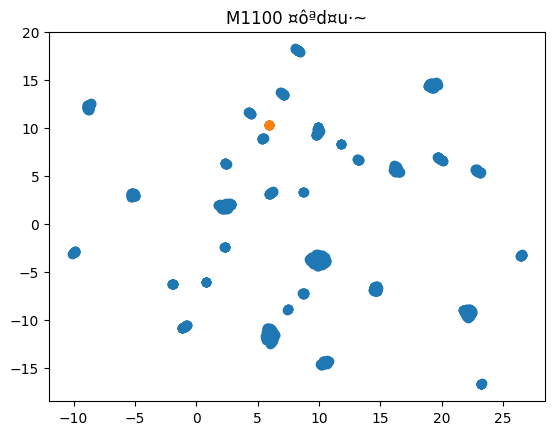

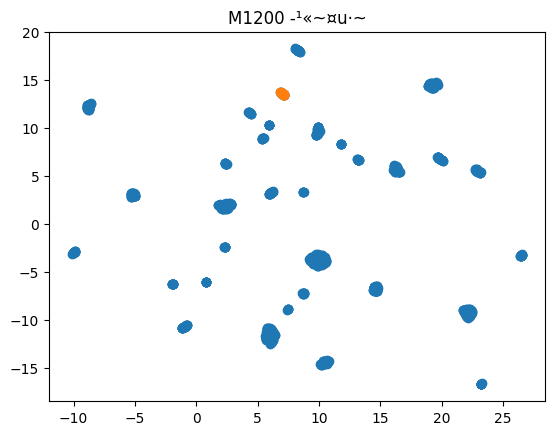

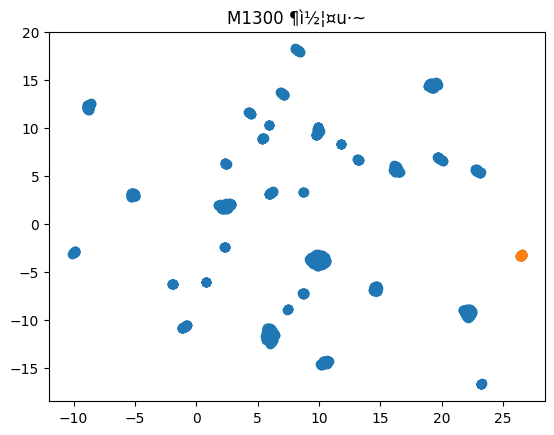

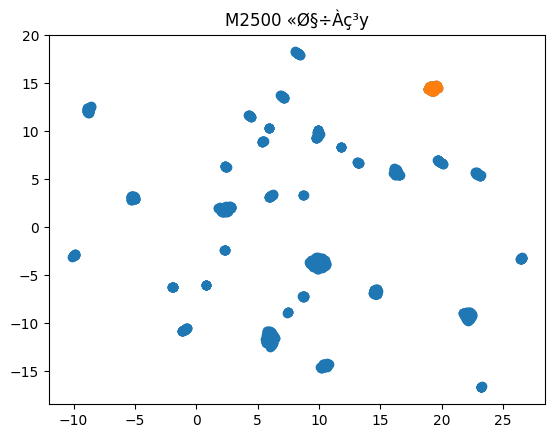

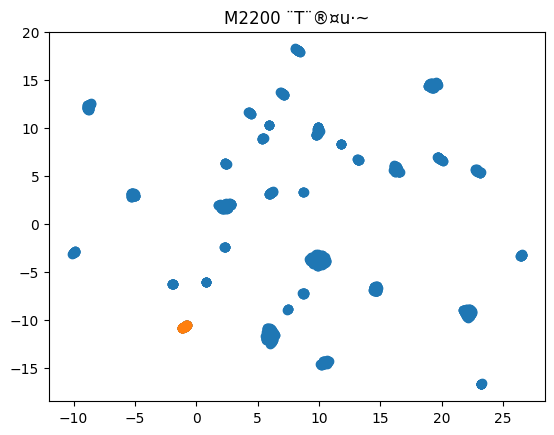

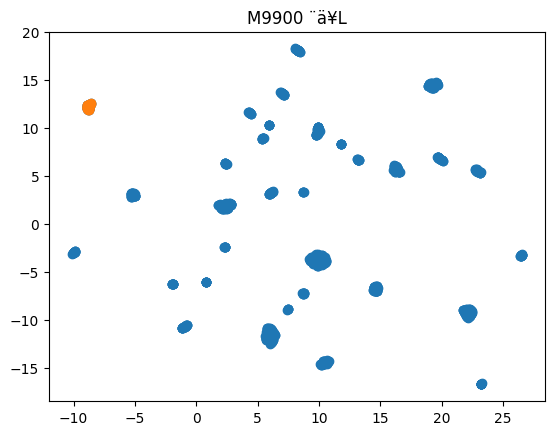

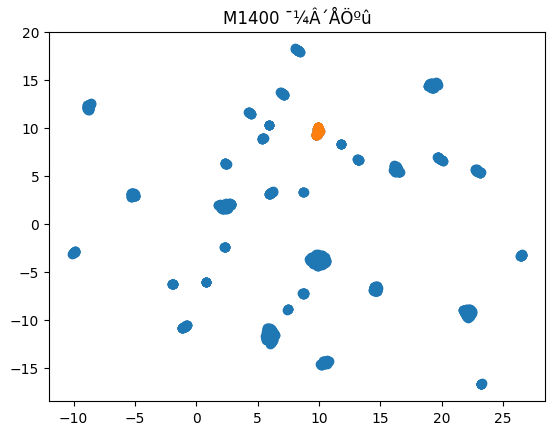

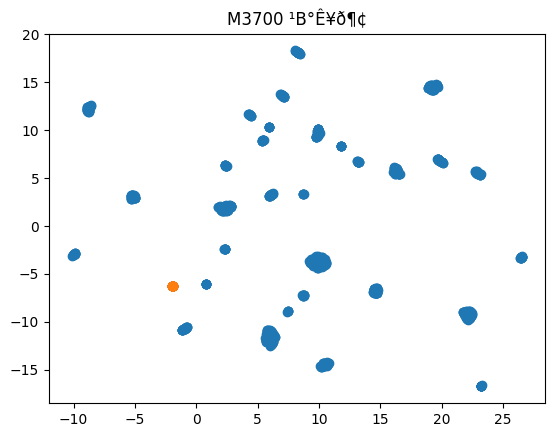

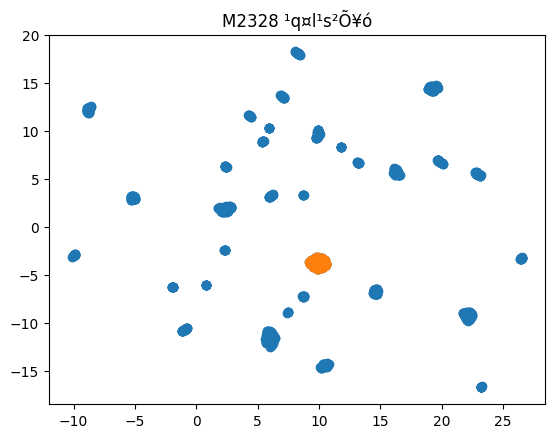

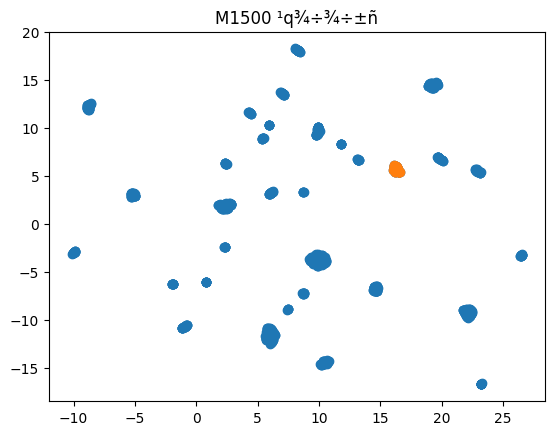

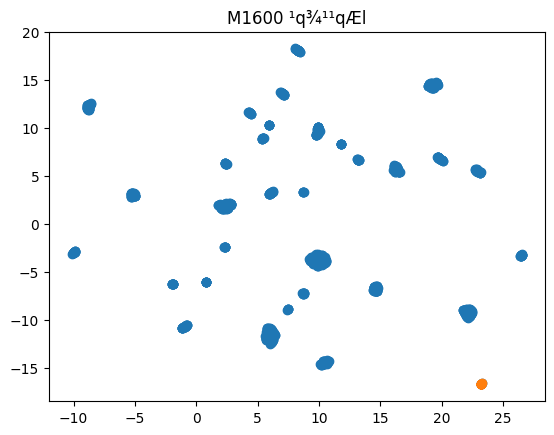

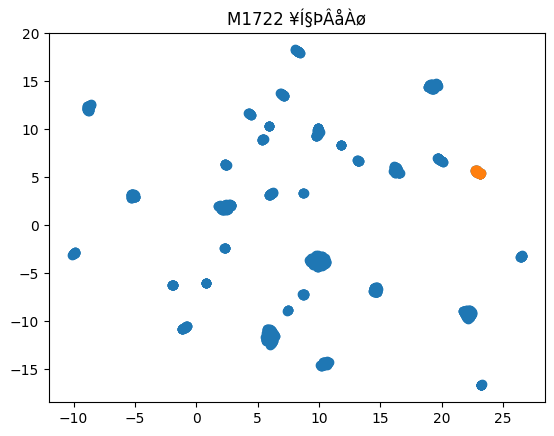

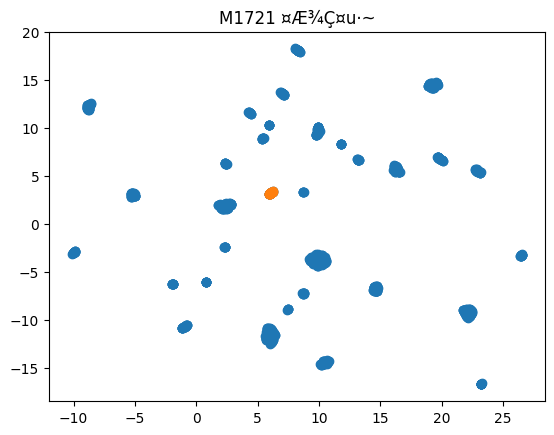

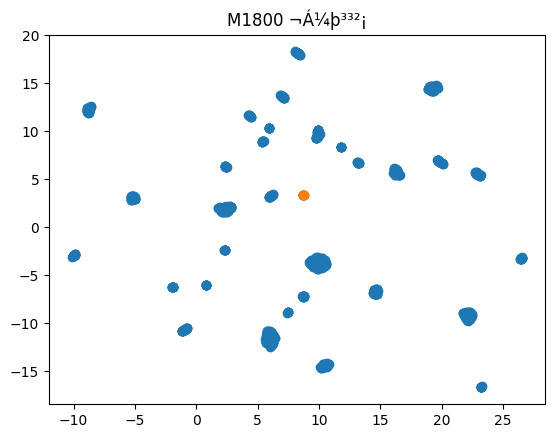

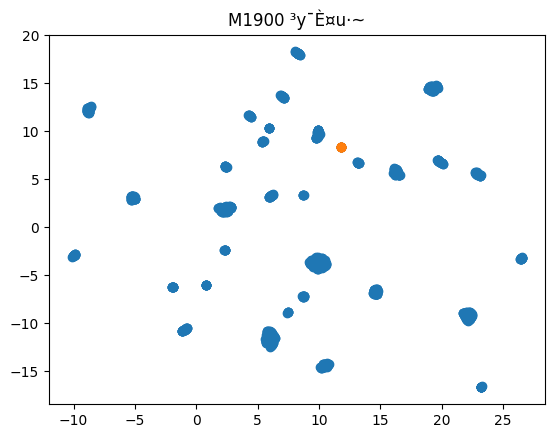

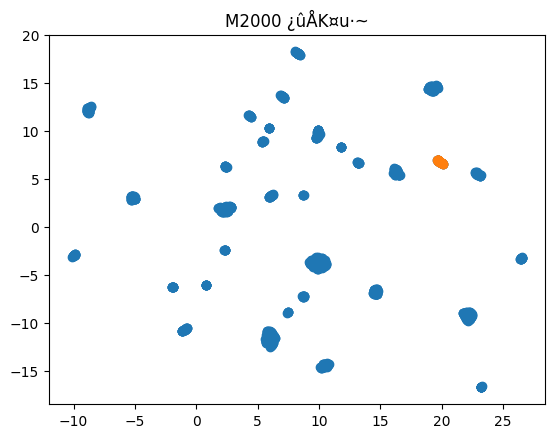

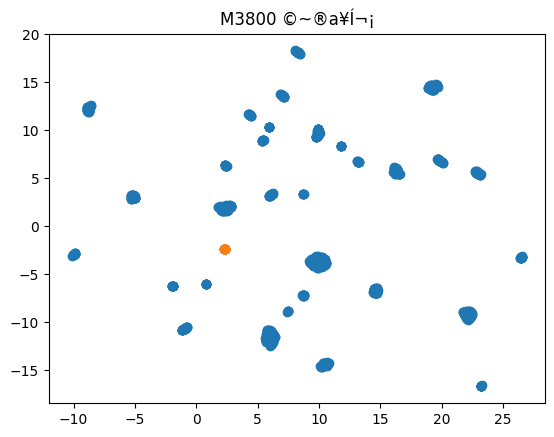

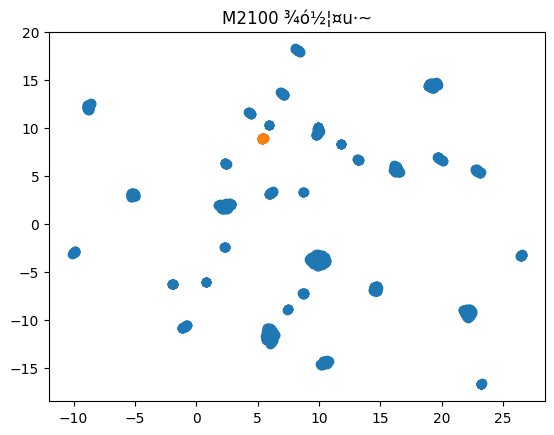

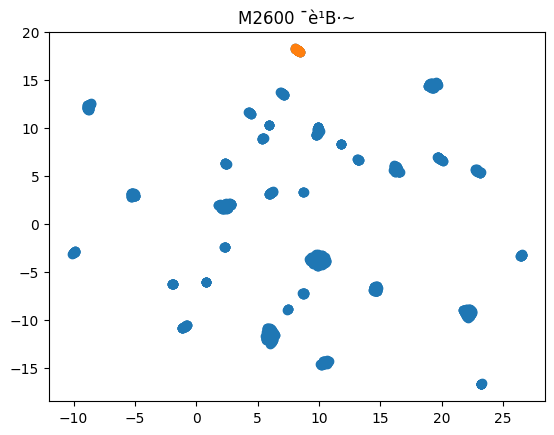

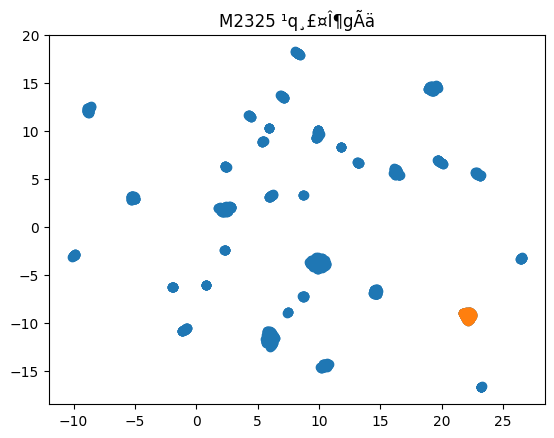

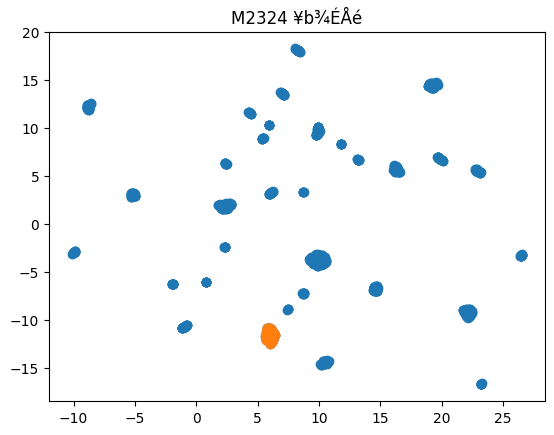

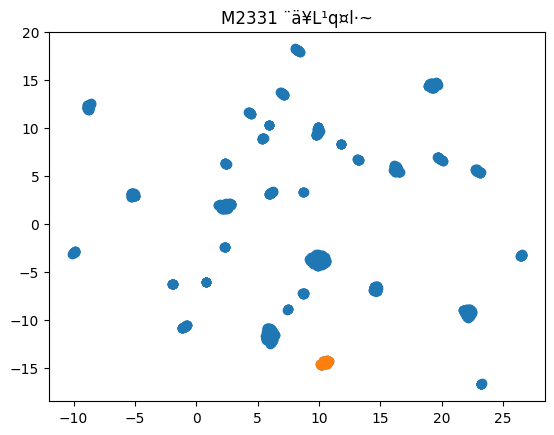

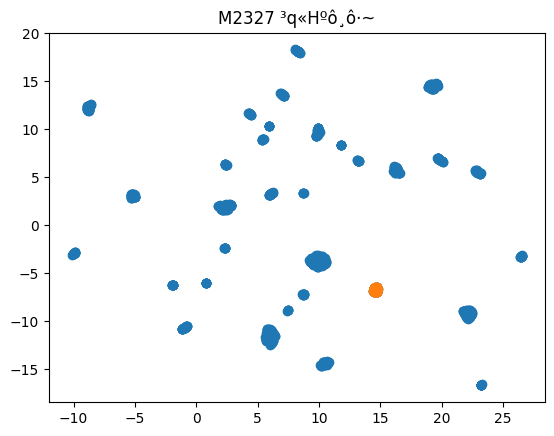

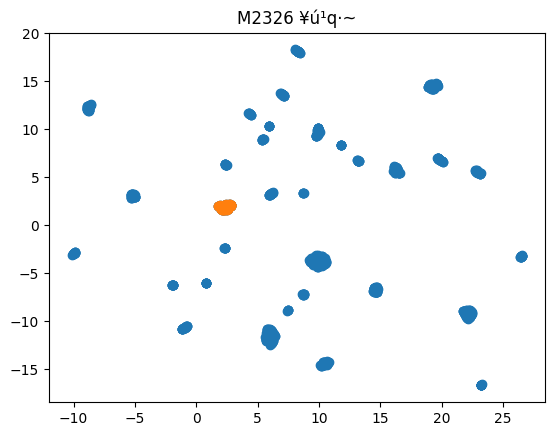

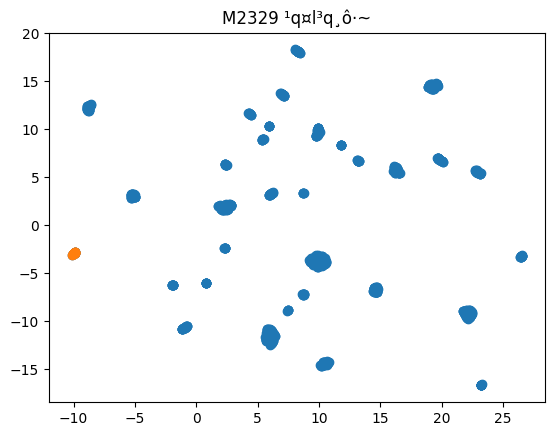

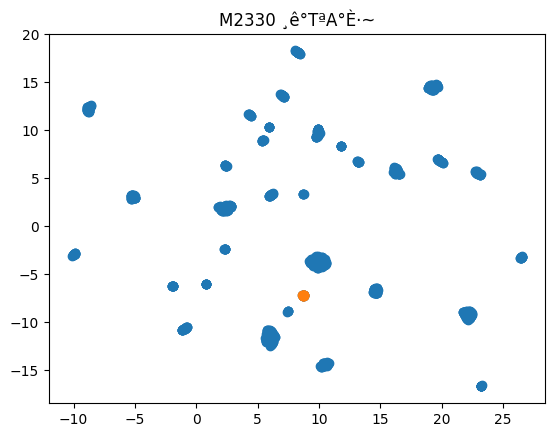

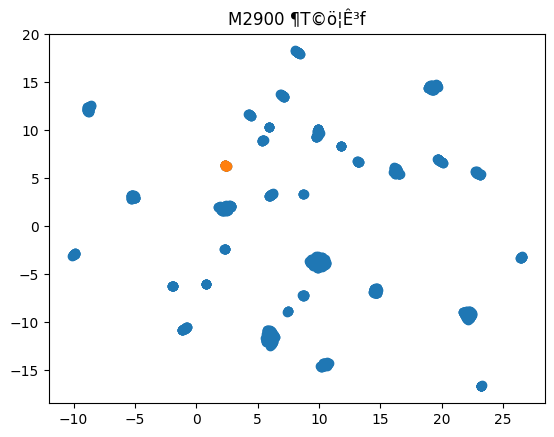

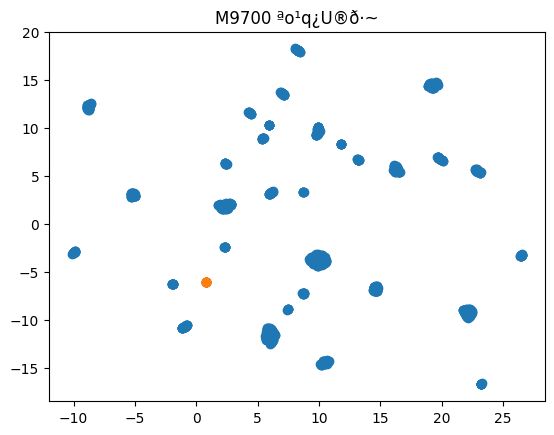

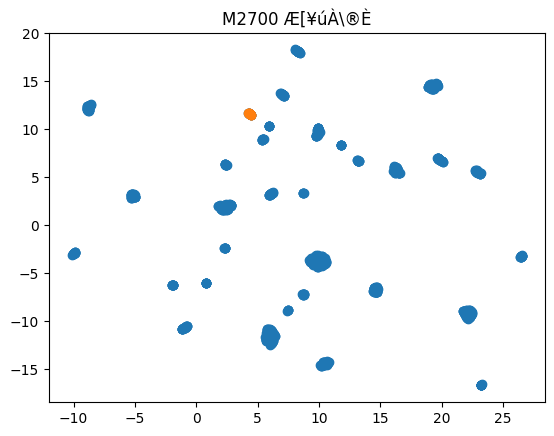

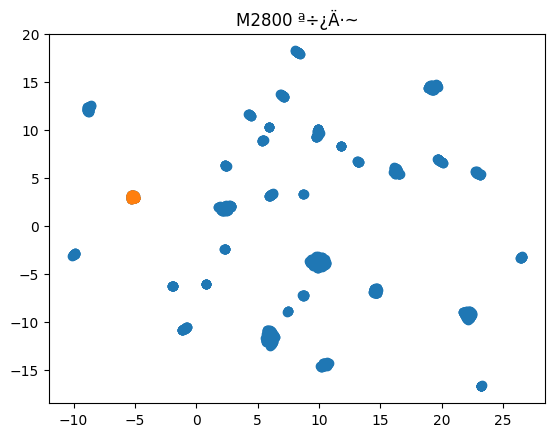

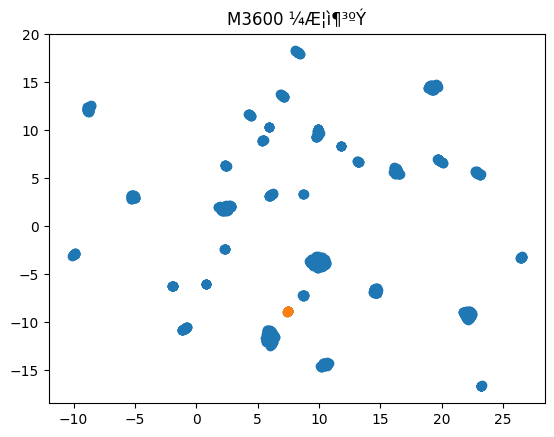

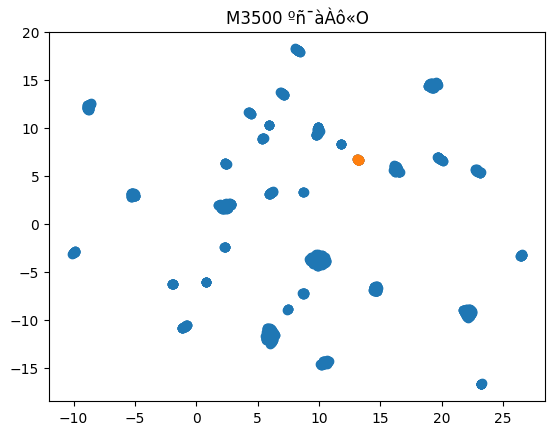

In [15]:
for industry in combined_df["Industry"].unique():
    industry_df = combined_df[combined_df["Industry"]==industry] 
    plt.scatter(combined_df["UMAP1"], combined_df["UMAP2"])
    plt.scatter(industry_df["UMAP1"], industry_df["UMAP2"])
    plt.title(f"{industry}")
    plt.show()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

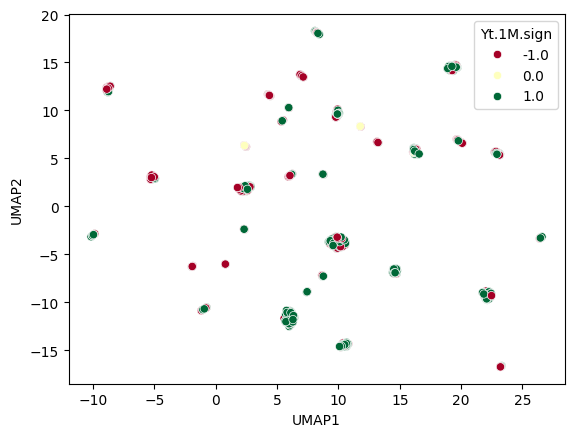

In [47]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5, linkage="complete", affinity='precomputed')
clusters_complete = model.fit_predict(distance_matrix)

c:\Users\USER\.conda\envs\rust-pruning\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


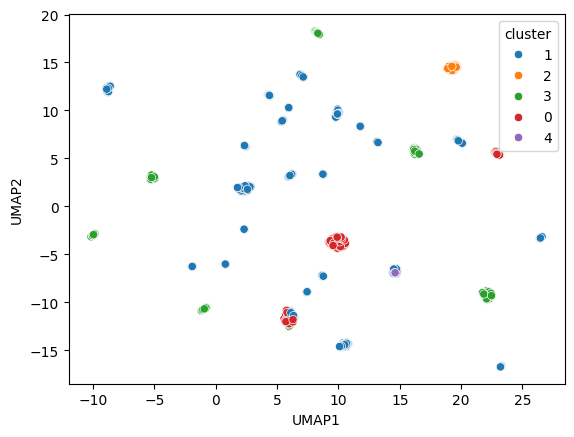

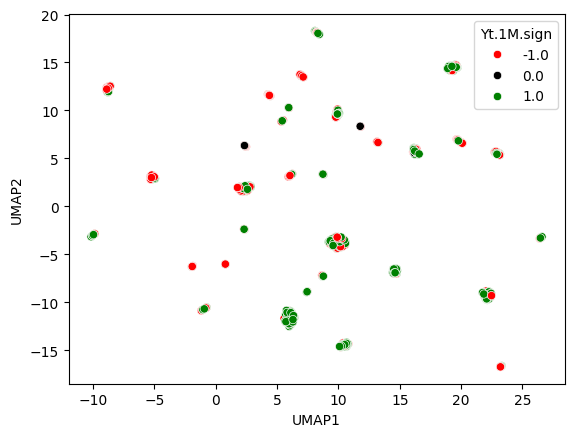

In [51]:
combined_df["cluster"] = np.asanyarray(clusters_complete)
combined_df["cluster"] = combined_df["cluster"].astype("str")
combined_df.to_csv("final.csv")
sns.scatterplot(combined_df, x="UMAP1", y="UMAP2", hue="cluster")
plt.show()
combined_df["Yt.1M.sign"] = np.sign(combined_df["Yt.1M"].to_numpy())
sns.scatterplot(combined_df, x="UMAP1", y="UMAP2", hue="Yt.1M.sign", palette= {-1: "red", 0: "black", 1: "green"})
plt.show()

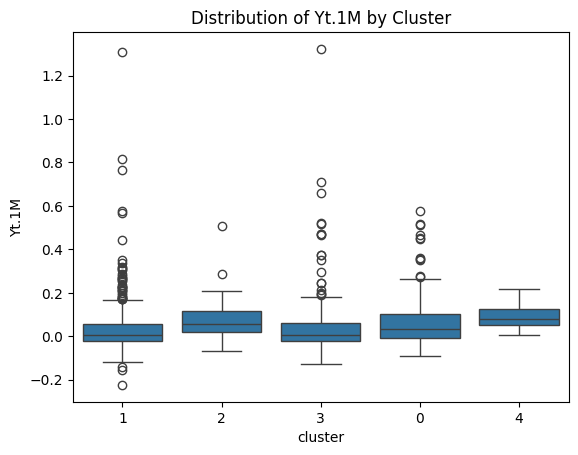

In [50]:
sns.boxplot(data=combined_df, x='cluster', y='Yt.1M')
plt.title("Distribution of Yt.1M by Cluster")
plt.show()

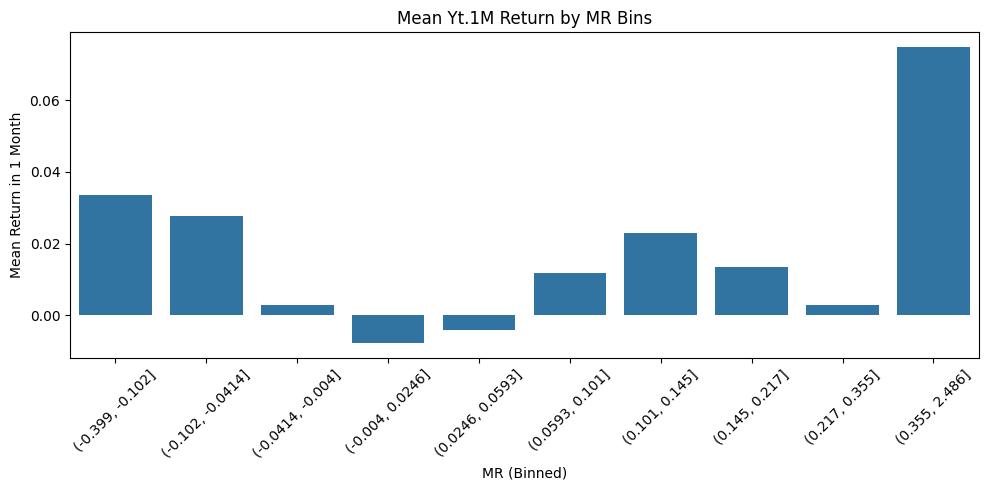

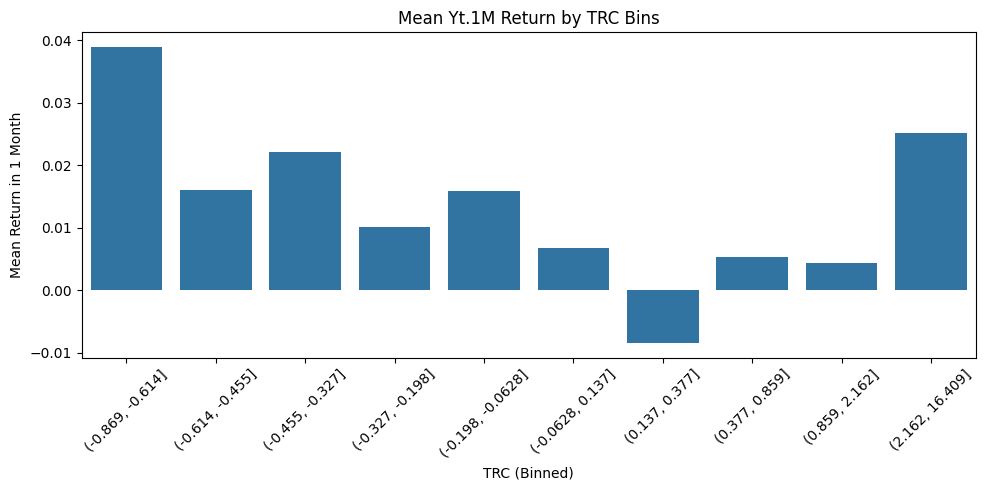

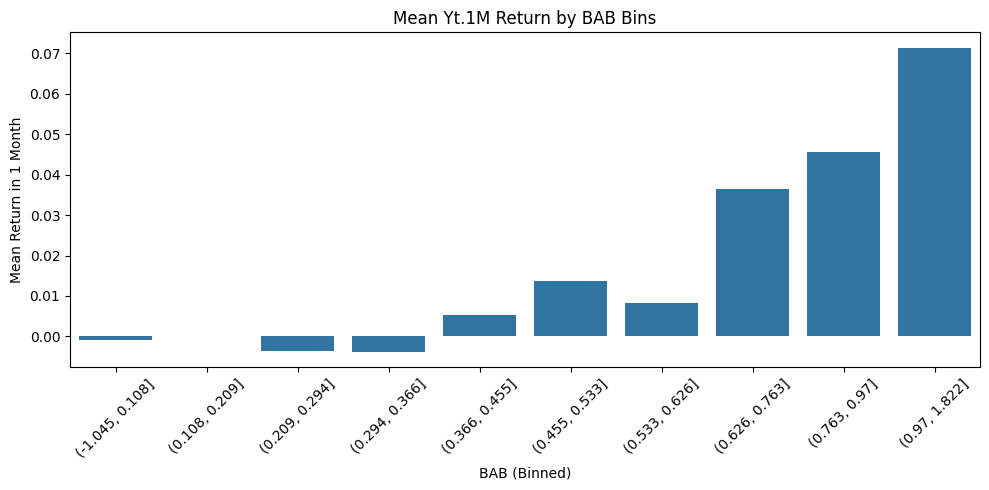

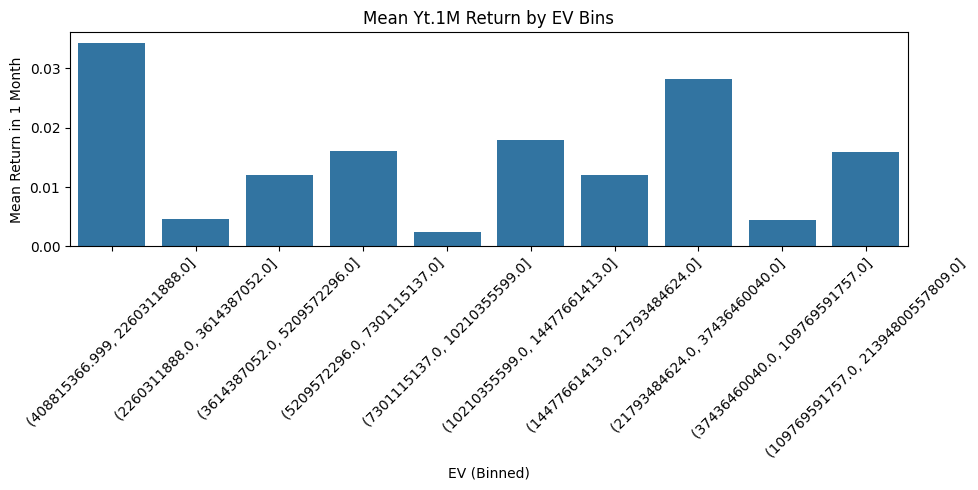

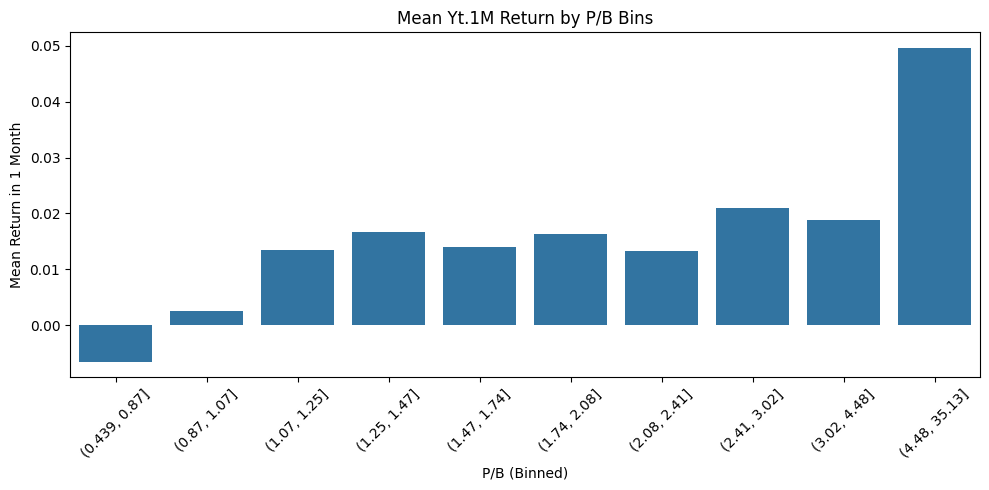

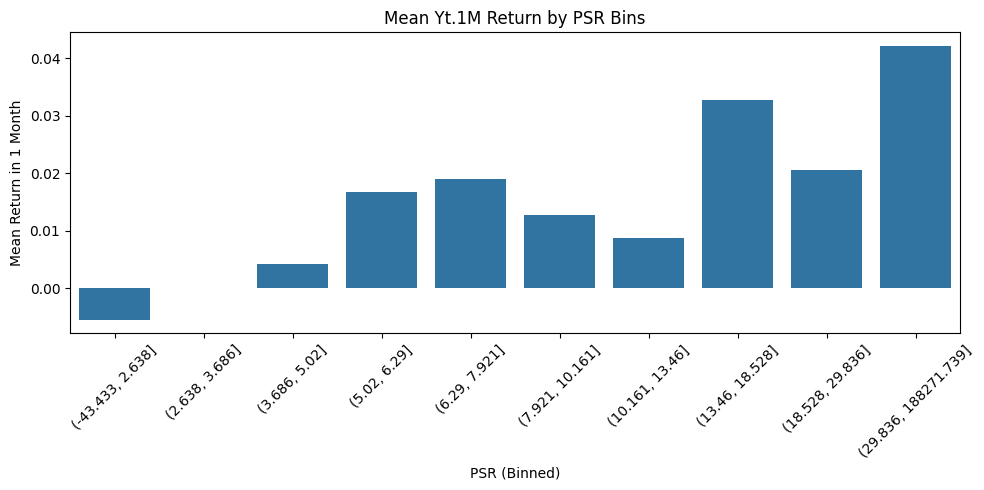

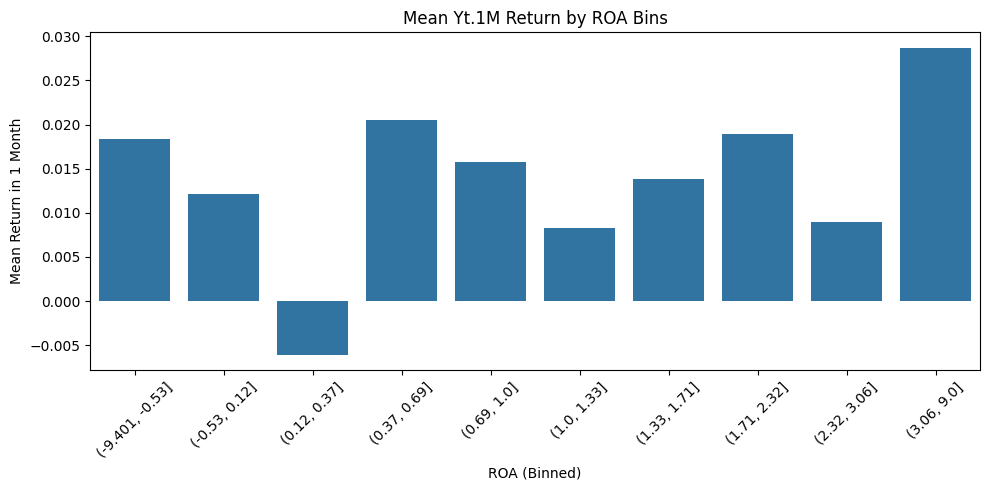

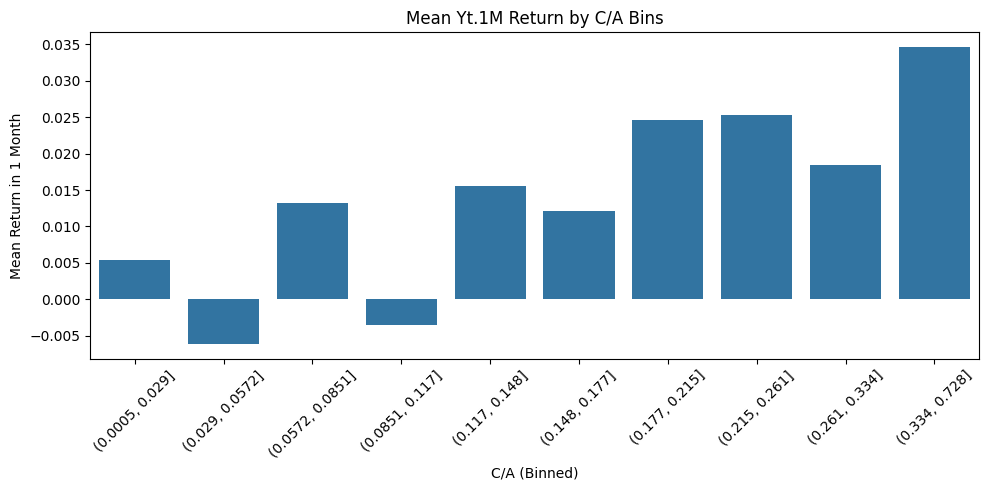

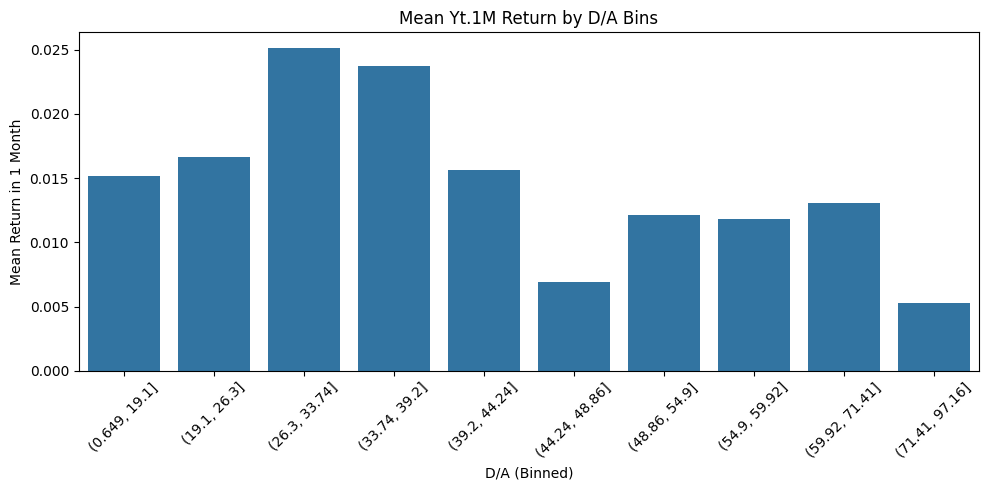

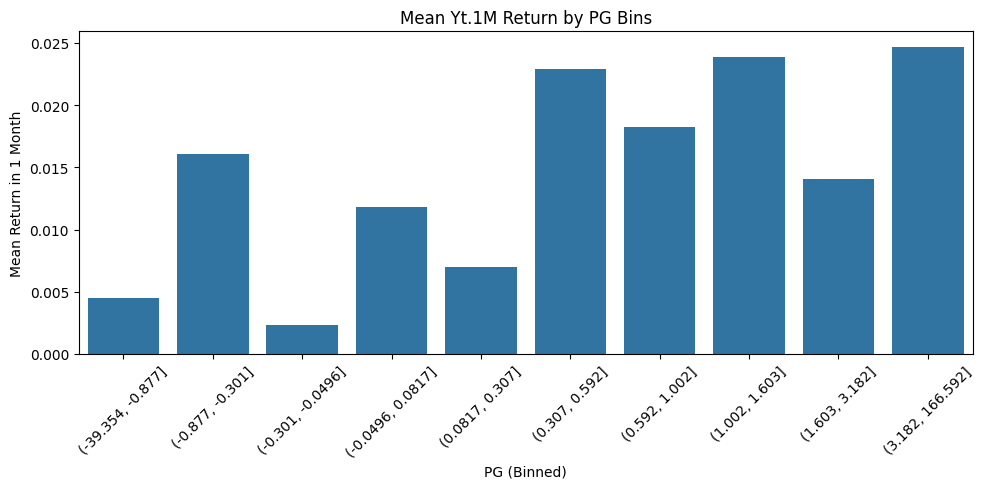

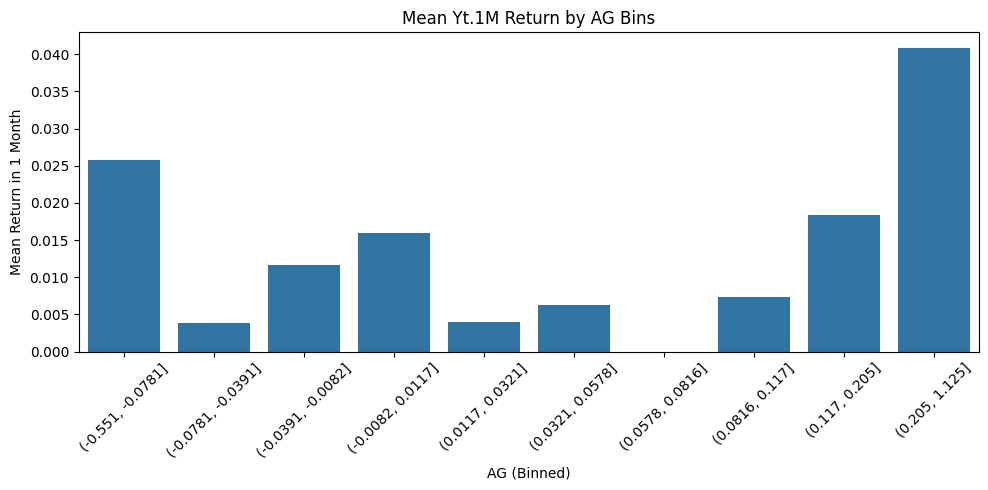

In [19]:
# Bin BAB into quantiles or fixed-width bins
for column in ["MR","TRC","BAB","EV","P/B","PSR","ROA","C/A","D/A","PG","AG"]:
    combined_df[f"{column}_bin"] = pd.qcut(combined_df[column], q=10, duplicates='drop')  # or use pd.cut

    # Calculate mean Yt.1M per bin
    bin_avg = combined_df.groupby(f'{column}_bin')['Yt.1M'].median().reset_index()

    # Bar plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=bin_avg, x=f"{column}_bin", y='Yt.1M')
    plt.xticks(rotation=45)
    plt.title(f'Mean Yt.1M Return by {column} Bins')
    plt.ylabel('Mean Return in 1 Month')
    plt.xlabel(f'{column} (Binned)')
    plt.tight_layout()
    plt.show()

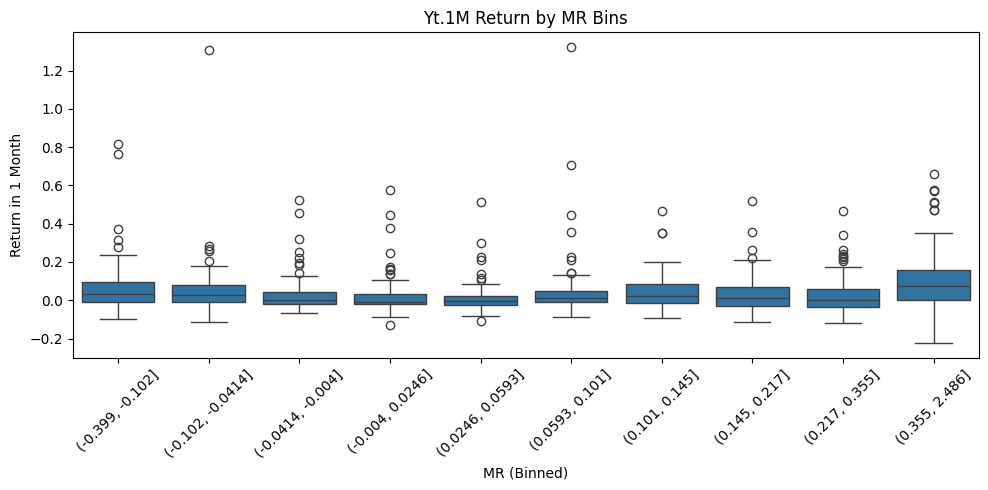

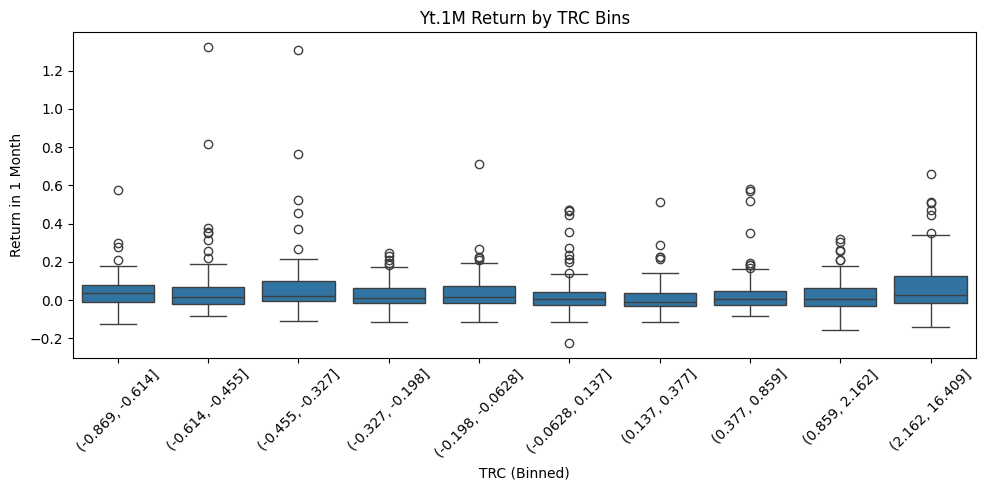

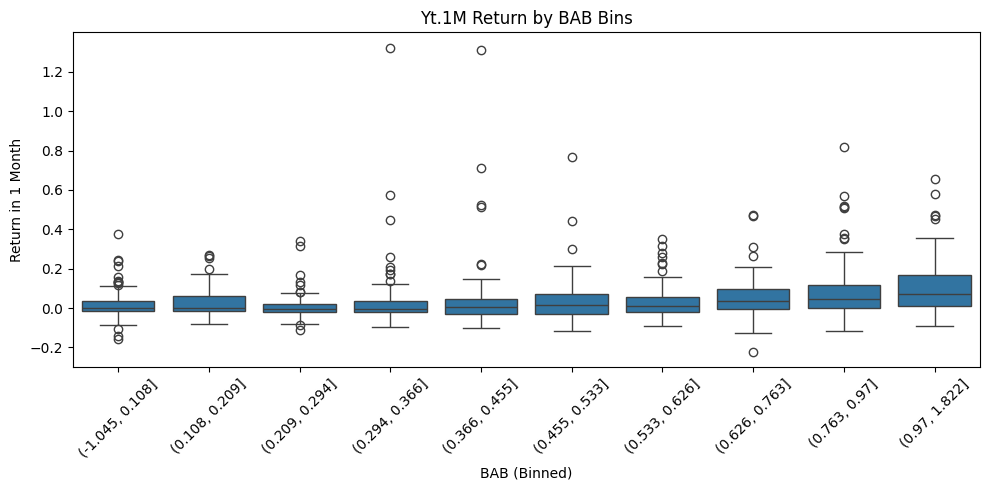

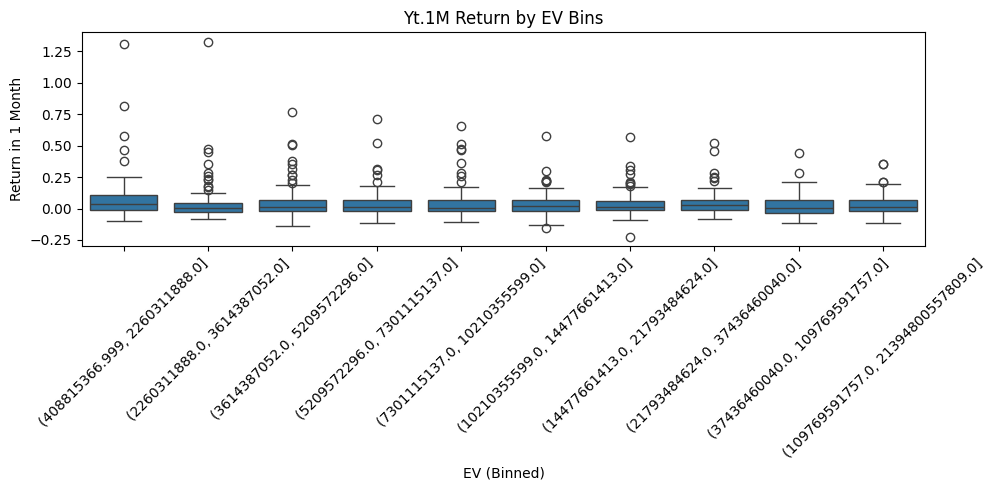

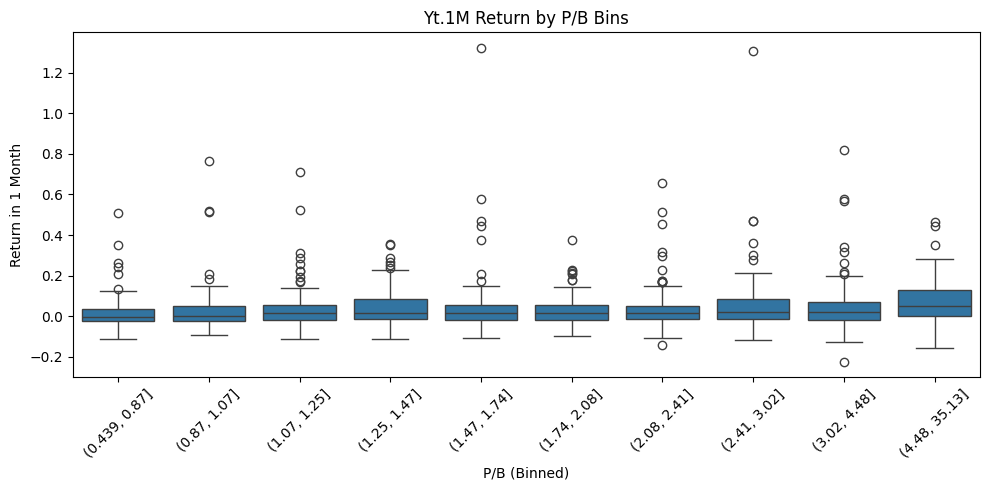

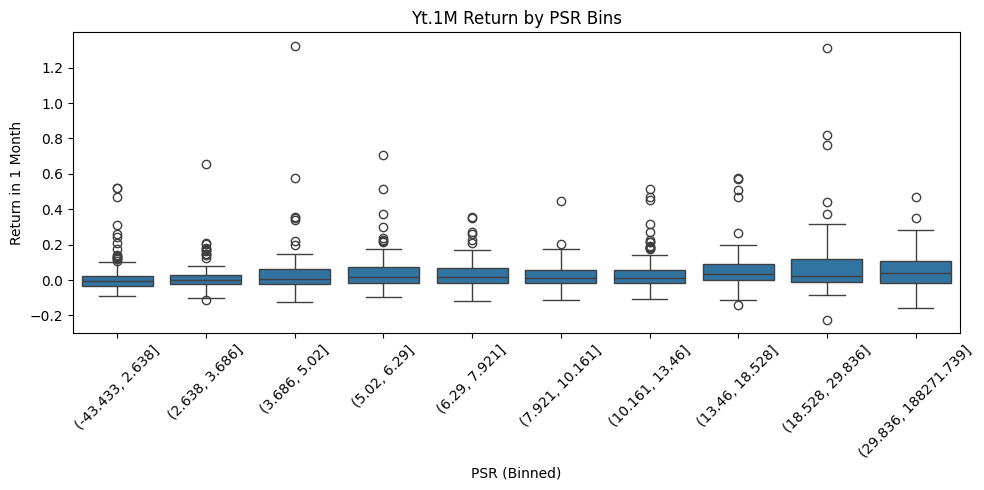

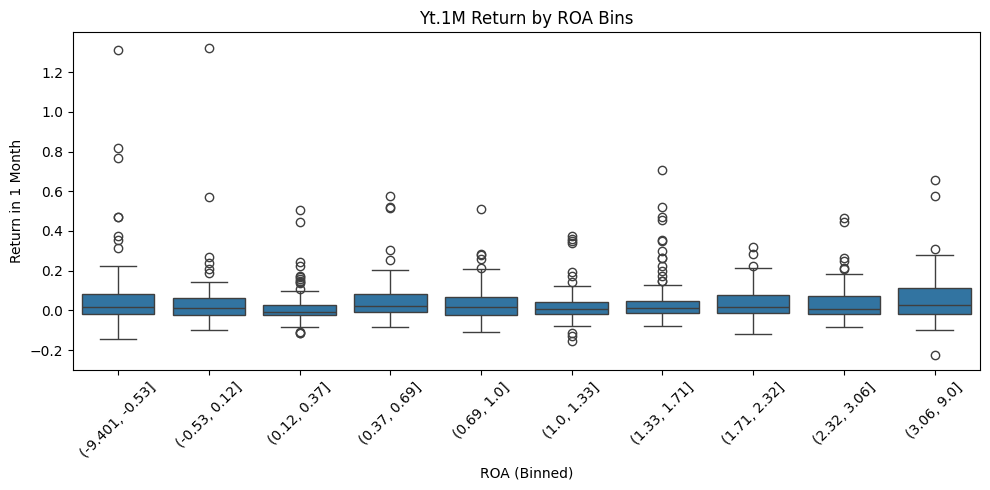

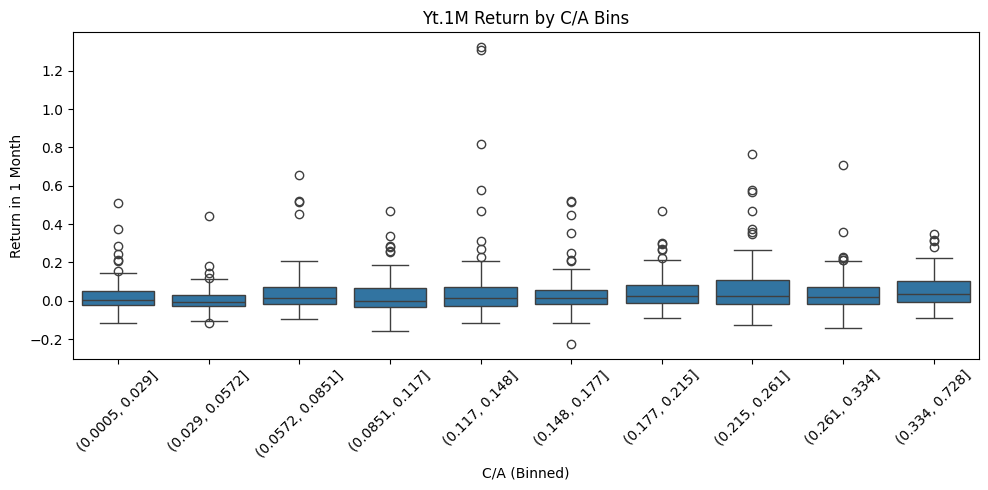

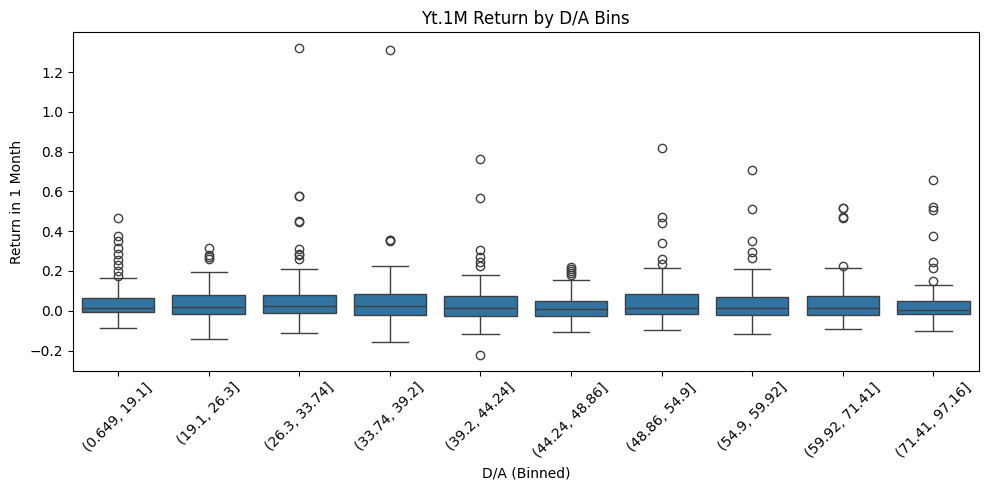

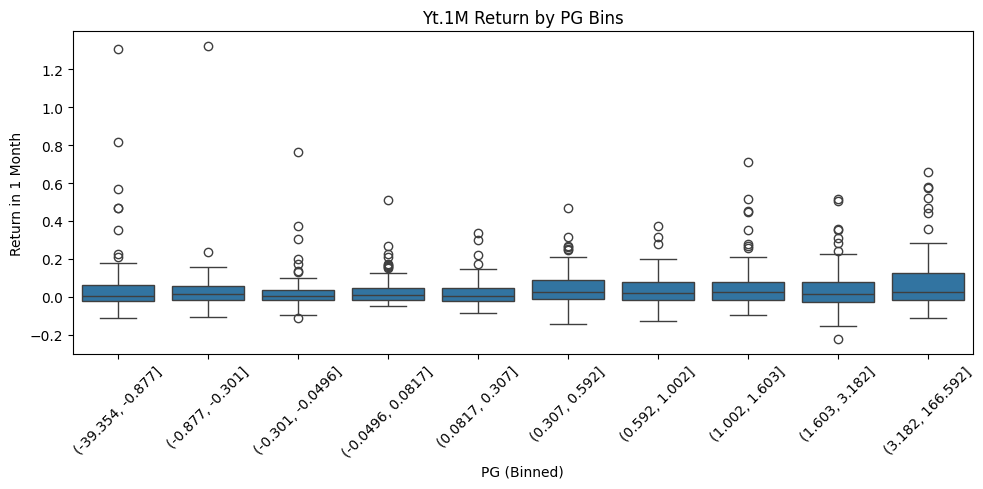

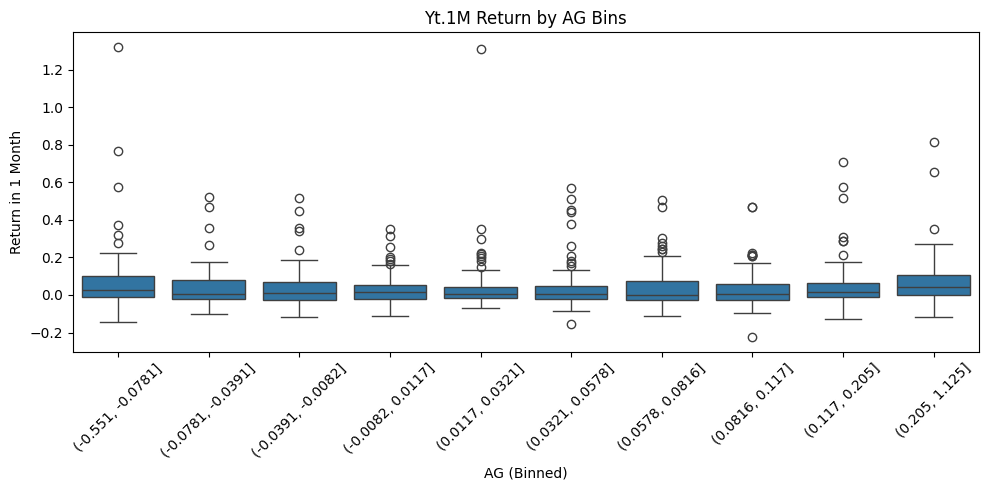

In [20]:
# Bin BAB into quantiles or fixed-width bins
for column in ["MR","TRC","BAB","EV","P/B","PSR","ROA","C/A","D/A","PG","AG"]:
    combined_df[f"{column}_bin"] = pd.qcut(combined_df[column], q=10, duplicates='drop')  # or use pd.cut

    # # Calculate mean Yt.1M per bin
    # bin_avg = combined_df.groupby(f'{column}_bin')['Yt.1M'].median().reset_index()

    # Bar plot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=combined_df, x=f"{column}_bin", y='Yt.1M')
    plt.xticks(rotation=45)
    plt.title(f'Yt.1M Return by {column} Bins')
    plt.ylabel('Return in 1 Month')
    plt.xlabel(f'{column} (Binned)')
    plt.tight_layout()
    plt.show()

In [53]:
combined_df.info()
columns = ["Yt.1M","Industry","MR","TRC","BAB","EV","P/B","PSR","ROA","C/A","D/A","PG","AG","cluster"]
final_df = combined_df[columns]
final_df.to_csv("final.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Yt.1M         911 non-null    float64 
 1   Industry      911 non-null    object  
 2   MR            911 non-null    float64 
 3   TRC           911 non-null    float64 
 4   BAB           911 non-null    float64 
 5   EV            911 non-null    float64 
 6   P/B           911 non-null    float64 
 7   PSR           911 non-null    float64 
 8   ROA           911 non-null    float64 
 9   C/A           911 non-null    float64 
 10  D/A           911 non-null    float64 
 11  PG            911 non-null    float64 
 12  AG            911 non-null    float64 
 13  UMAP1         911 non-null    float32 
 14  UMAP2         911 non-null    float32 
 15  Yt.1M.scaled  911 non-null    float64 
 16  Yt.1M.sign    911 non-null    float64 
 17  MR_bin        911 non-null    category
 18  TRC_bin   